<a href="https://colab.research.google.com/github/hnwestpage/Fusion-ML-COVID-19/blob/main/FeatFusionStudyCovid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating biomedical feature fusion on machine learning's predictability and interpretability of severe COVID-19
-Haleigh (Hal) West-Page, Shi Chen and Kevin McGoff

In [ ]:
# Mounting Google Drive

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Title: Package imports

# Description: Importing external libraries and packages
#-------------------------------------------------------------------------------

# Data retrieval and organization
import csv
import pandas as pd
import numpy as np
from numpy.core.fromnumeric import transpose

# Preprocessing, train-test splitting, and hyperparmeter tuning
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

# Machine learning methods
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

# Performance evaluation and graph displays
from sklearn import metrics
import math
from statistics import mean
import matplotlib.pyplot as plt

## Upload original COVID-19 patient data

In [ ]:
# Title: Separate (function)

# Description: Function written to separate labels from features of dataset
#-------------------------------------------------------------------------------
def separate(data):
  train = data.loc[:, data.columns != 'COVID']
  labels = data.loc[:, 'COVID'].values
  return train, labels

In [ ]:
# Title: Reading the data: Original strain COVID

# Description: This block handles reading and saving the data from .csv files in
#              the data folder. This section also sends the arrays to the above
#              "Separate" function to split the labels from the features.
#-------------------------------------------------------------------------------

# Reading blood chemistry dataset
bioChem = pd.read_csv("/content/drive/MyDrive/Research/CDC HAI Modeling Project/Project 3 -- Hal/Task 1- ML/MFCSM's/Data/READbiochem.csv", header=0)
bioChem_df = pd.DataFrame(bioChem)
bioChem_df['COVID'] = bioChem.COVID

# Reading clinical characteristics dataset
symp = pd.read_csv("/content/drive/MyDrive/Research/CDC HAI Modeling Project/Project 3 -- Hal/Task 1- ML/MFCSM's/Data/READsymptomEDIT.csv", header=0)
symp_df = pd.DataFrame(symp)
symp_df['COVID'] = symp.COVID

# Reading combined multimodal dataset
multi = pd.read_csv("/content/drive/MyDrive/Research/CDC HAI Modeling Project/Project 3 -- Hal/Task 1- ML/MFCSM's/Data/READfusionEDIT.csv", header=0)
multi_df = pd.DataFrame(multi)
multi_df['COVID'] = multi.COVID

# Separating into labels and features
bioChem_trim, bioChem_labels = separate(bioChem)
symp_trim, symp_labels = separate(symp)
multi_trim, multi_labels = separate(multi)

## Upload Omicron variant COVID-19 patient data

In [ ]:
# Title: Reading the data: Omicron variant COVID

# Description: This block handles reading and saving the data from .csv files in
#              the data folder. This section also sends the arrays to the above
#              "Separate" function to split the labels from the features.
#-------------------------------------------------------------------------------
# Reading blood chemistry dataset
bioChemO = pd.read_csv("/content/drive/MyDrive/Research/CDC HAI Modeling Project/Project 3 -- Hal/Task 1- ML/MFCSM's/Data/Omicron/READcovomicronchem.csv", header=0)
bioChemO_df = pd.DataFrame(bioChem)
bioChemO_df['COVID'] = bioChem.COVID

# Reading clinical characteristics dataset
sympO = pd.read_csv("/content/drive/MyDrive/Research/CDC HAI Modeling Project/Project 3 -- Hal/Task 1- ML/MFCSM's/Data/Omicron/READcovomicronsymp.csv", header=0)
symp_dfO = pd.DataFrame(symp)
symp_dfO['COVID'] = symp.COVID

# Reading combined multimodal dataset
multiO = pd.read_csv("/content/drive/MyDrive/Research/CDC HAI Modeling Project/Project 3 -- Hal/Task 1- ML/MFCSM's/Data/Omicron/READcovomicronFusion.csv", header=0)
multiO_df = pd.DataFrame(multi)
multiO_df['COVID'] = multi.COVID

# Separating into labels and features
bioChemO_trim, bioChemO_labels = separate(bioChemO)
sympO_trim, sympO_labels = separate(sympO)
multiO_trim, multiO_labels = separate(multiO)

In [ ]:
# Toggle Number of Runs
n_runs = 50

In [ ]:
# Title: Counting Hyperparameters from list

# Description: This block reads a list of dictionaries and counts the frequency
#              of each one, adding it to a larger dictionary. This is to get a
#              counthow many times a hyperparameter was the optimal choice for a
#              given model.
#-------------------------------------------------------------------------------
def CountParams(d):
  hyParams = {}

  for each in d:
    if each in hyParams:
      hyParams[each] += 1
    else:
      hyParams[each] = 1

  return hyParams

## Logistic Regression



### Original Trained Model


---





#### Hyperparameter Tuning, Training, and Prediction

In [ ]:
# Logistic Regression - Original------------------------------------------------

print('Original Data Runs\n')

# Parameter Grid
parameters = {'penalty': (None, 'l1', 'l2')}

# FPR recordings: 1-TNR, for plotting AUC
bc_fpr_runs = [] # Original Trained and Tested
sy_fpr_runs = []
fn_fpr_runs = []

bc_fpr_runs1 = [] # Original Trained and Omicron Tested
sy_fpr_runs1 = []
fn_fpr_runs1 = []

# TPR recordings: Sensitivity, Recall
bc_tpr_runs = [] # Original Trained and Tested
sy_tpr_runs = []
fn_tpr_runs = []

bc_tpr_runs1 = [] # Original Trained and Omicron Tested
sy_tpr_runs1 = []
fn_tpr_runs1 = []
"""
# TNR recordings: Specificity, Sensitivity
bc_tnr_runs = [] # Original Trained and Tested
sy_tnr_runs = []
fn_tnr_runs = []

bc_tnr_runs1 = [] # Original Trained and Omicron Tested
sy_tnr_runs1 = []
fn_tnr_runs1 = []
"""
# AUC recordings
bc_auc_runs = [] # Original Trained and Tested
sy_auc_runs = []
fn_auc_runs = []

bc_auc_runs1 = [] # Original Trained and Omicron Tested
sy_auc_runs1 = []
fn_auc_runs1 = []

# Coefficient recordings
bc_coeffs = []
sy_coeffs = []
fn_coeffs = []

# Best parameter recordings
bc_params = []
sy_params = []
fn_params = []

for i in range(n_runs):
  j = i+1
  print('Run: ',j,' ------------------------------------\n')

  # Train Test Split------------------------------------------------------------
  bioChem_train, bioChem_test, bioChem_labels_train, bioChem_labels_test = train_test_split(bioChem_trim, bioChem_labels, test_size = 1 / 5)
  symp_train, symp_test, symp_labels_train, symp_labels_test = train_test_split(symp_trim, symp_labels, test_size = 1 / 5)
  multi_train, multi_test, multi_labels_train, multi_labels_test = train_test_split(multi_trim, multi_labels, test_size = 1 / 5)

  # Scaling---------------------------------------------------------------------
  # Biochemical Data
  bioChem_scaler = StandardScaler()
  bioChem_train = bioChem_scaler.fit_transform(bioChem_train)
  bioChem_test = bioChem_scaler.transform(bioChem_test)

  # Clinical Data
  symp_scaler = StandardScaler()
  symp_train = symp_scaler.fit_transform(symp_train)
  symp_test = symp_scaler.transform(symp_test)

  # Fusion Data
  multi_scaler = StandardScaler()
  multi_train = multi_scaler.fit_transform(multi_train)
  multi_test = multi_scaler.transform(multi_test)

  # Model Training Grid Search--------------------------------------------------
  # Biochemical model
  bioChem_LR = LogisticRegression(solver='saga',max_iter=10000)
  bioChem_clf = GridSearchCV(bioChem_LR, parameters)
  bioChem_clf.fit(bioChem_train, bioChem_labels_train)

  # Clinical model
  symp_LR = LogisticRegression(solver='saga',max_iter=10000)
  symp_clf = GridSearchCV(symp_LR, parameters)
  symp_clf.fit(symp_train, symp_labels_train)

  # Fusion model
  multi_LR = LogisticRegression(solver='saga',max_iter=10000)
  multi_clf = GridSearchCV(multi_LR, parameters)
  multi_clf.fit(multi_train, multi_labels_train)

  # View results----------------------------------------------------------------
  target_names = ['Non-Severe COVID', 'Severe COVID']

  # Biochemical results---------------------------------------------------------
  #print('Biochemical Results\n')

  # Recording Best estimator
  bc_params.append(bioChem_clf.best_params_)

  # Recording Biochemical feature coefficients
  bc_coeffs.append(bioChem_clf.best_estimator_.coef_[0])

  """feature_importance_1 = pd.DataFrame({'Feature': bioChem_trim.columns, 'Importance': np.abs(bc_coeffs)})
  print('Feature ranking for severe COVID-19:\n', feature_importance_1.nlargest(5, 'Importance', keep='all'))"""

  # Predicting on testing hold-out data
  bioChem_labels_predict = bioChem_clf.predict(bioChem_test)

  # Predicting on Omicron Data
  bioChemO_trim_scale = bioChem_scaler.transform(bioChemO_trim)
  bioChemO_labels_predict = bioChem_clf.predict(bioChemO_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(bioChem_labels_test, bioChem_labels_predict, pos_label=1)
  bc_fpr_runs.append(fpr)
  bc_tpr_runs.append(tpr)

  # Omicron testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(bioChemO_labels, bioChemO_labels_predict)
  bc_fpr_runs1.append(fpr1)
  bc_tpr_runs1.append(tpr1)

  # AUC
  BC_roc_auc = metrics.auc(fpr, tpr)
  bc_auc_runs.append(BC_roc_auc)

  # AUC - Omicron
  BC_roc_auc1 = metrics.auc(fpr1, tpr1)
  bc_auc_runs1.append(BC_roc_auc1)

  # Clinical results------------------------------------------------------------
  #print('Clinical Results\n')

  # Best estimator
  sy_params.append(symp_clf.best_params_)

  # Top 5 Clinical features
  sy_coeffs.append(symp_clf.best_estimator_.coef_[0])

  """feature_importance_2 = pd.DataFrame({'Feature': symp_trim.columns, 'Importance': np.abs(sy_coeffs)})
  print('Feature ranking for severe COVID-19:\n', feature_importance_2.nlargest(5, 'Importance', keep='all'))"""

  # Predicting on testing hold-out data
  symp_labels_predict = symp_clf.predict(symp_test)

  # Predicting on Omicron Data
  sympO_trim_scale = symp_scaler.transform(sympO_trim)
  sympO_labels_predict = symp_clf.predict(sympO_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(symp_labels_test, symp_labels_predict)
  sy_fpr_runs.append(fpr)
  sy_tpr_runs.append(tpr)

  # Omicron testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(sympO_labels,sympO_labels_predict)
  sy_fpr_runs1.append(fpr1)
  sy_tpr_runs1.append(tpr1)

  # AUC
  SY_roc_auc = metrics.auc(fpr, tpr)
  sy_auc_runs.append(SY_roc_auc)

  # AUC - Omicron
  SY_roc_auc1 = metrics.auc(fpr1, tpr1)
  sy_auc_runs1.append(SY_roc_auc1)

  # Fusion results--------------------------------------------------------------
  #print('Fusion Results\n')

  # Best estimator
  fn_params.append(multi_clf.best_params_)

  # Top 5 Fusion features
  fn_coeffs.append(multi_clf.best_estimator_.coef_[0])

  """feature_importance_3 = pd.DataFrame({'Feature': multi_trim.columns, 'Importance': np.abs(fn_coeffs)})
  print('Feature ranking for severe COVID-19:\n', feature_importance_3.nlargest(5, 'Importance', keep='all'))"""

  # Predicting on testing hold-out data
  multi_labels_predict = multi_clf.predict(multi_test)

  # Predicting on Omicron Data
  multiO_trim_scale = multi_scaler.transform(multiO_trim)
  multiO_labels_predict = multi_clf.predict(multiO_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(multi_labels_test, multi_labels_predict)
  fn_fpr_runs.append(fpr)
  fn_tpr_runs.append(tpr)

  # Omicron testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(multiO_labels, multiO_labels_predict)
  fn_fpr_runs1.append(fpr1)
  fn_tpr_runs1.append(tpr1)

  # AUC
  FN_roc_auc = metrics.auc(fpr, tpr)
  fn_auc_runs.append(FN_roc_auc)

  # AUC - Omicron
  FN_roc_auc1 = metrics.auc(fpr1, tpr1)
  fn_auc_runs1.append(FN_roc_auc1)

print(bc_params)
print(sy_params)
print(fn_params)

Original Data Runs

Run:  1  ------------------------------------

Run:  2  ------------------------------------

Run:  3  ------------------------------------

Run:  4  ------------------------------------

Run:  5  ------------------------------------

Run:  6  ------------------------------------

Run:  7  ------------------------------------

Run:  8  ------------------------------------

Run:  9  ------------------------------------

Run:  10  ------------------------------------

Run:  11  ------------------------------------

Run:  12  ------------------------------------

Run:  13  ------------------------------------

Run:  14  ------------------------------------

Run:  15  ------------------------------------

Run:  16  ------------------------------------

Run:  17  ------------------------------------

Run:  18  ------------------------------------

Run:  19  ------------------------------------

Run:  20  ------------------------------------

Run:  21  -------------------

#### Calculating Mean and Standard deviation of metrics

In [ ]:
def get_Stats(fpr_runs,fpr_runs1,tpr_runs,tpr_runs1,auc_runs,auc_runs1):
  # Averages
  avg_fpr = np.mean(fpr_runs, axis=0)
  avg_fpr1 = np.mean(fpr_runs1, axis=0)
  avg_tpr = np.mean(tpr_runs, axis=0)
  avg_tpr1 = np.mean(tpr_runs1, axis=0)
  avg_auc = np.mean(auc_runs)
  avg_auc1 = np.mean(auc_runs1)

  # Standard Deviations
  std_fpr = np.std(fpr_runs, axis=0)
  std_fpr1 = np.std(fpr_runs1, axis=0)
  std_tpr = np.std(tpr_runs, axis=0)
  std_tpr1 = np.std(tpr_runs1, axis=0)
  std_auc = np.std(auc_runs)
  std_auc1 = np.std(auc_runs1)

  return avg_fpr, avg_fpr1, avg_tpr, avg_tpr1, avg_auc, avg_auc1, std_fpr, std_fpr1, std_tpr, std_tpr1, std_auc, std_auc1

In [ ]:
bc_avg_fpr, bc_avg_fpr1, bc_avg_tpr, bc_avg_tpr1, bc_avg_auc, bc_avg_auc1, bc_std_fpr, bc_std_fpr1, bc_std_tpr, bc_std_tpr1, bc_std_auc, bc_std_auc1 = get_Stats(bc_fpr_runs,bc_fpr_runs1,bc_tpr_runs,bc_tpr_runs1,bc_auc_runs,bc_auc_runs1)
sy_avg_fpr, sy_avg_fpr1, sy_avg_tpr, sy_avg_tpr1, sy_avg_auc, sy_avg_auc1, sy_std_fpr, sy_std_fpr1, sy_std_tpr, sy_std_tpr1, sy_std_auc, sy_std_auc1 = get_Stats(sy_fpr_runs,sy_fpr_runs1,sy_tpr_runs,sy_tpr_runs1,sy_auc_runs,sy_auc_runs1)
fn_avg_fpr, fn_avg_fpr1, fn_avg_tpr, fn_avg_tpr1, fn_avg_auc, fn_avg_auc1, fn_std_fpr, fn_std_fpr1, fn_std_tpr, fn_std_tpr1, fn_std_auc, fn_std_auc1 = get_Stats(fn_fpr_runs,fn_fpr_runs1,fn_tpr_runs,fn_tpr_runs1,fn_auc_runs,fn_auc_runs1)

# Mean coefficients
bc_mean_coeffs = np.mean(bc_coeffs, axis=0)
sy_mean_coeffs = np.mean(sy_coeffs, axis=0)
fn_mean_coeffs = np.mean(fn_coeffs, axis=0)

#### Printing Stats

In [ ]:
# Printing Results--------------------------------------------------------------
# FPR
print('Mean FPR, original/original, BC: ', bc_avg_fpr)
print('Mean FPR, original/original, SY: ', sy_avg_fpr)
print('Mean FPR, original/original, FN: ', fn_avg_fpr)

# FPR - Omicron
print('Mean FPR, original/omicron, BC: ', bc_avg_fpr1)
print('Mean FPR, original/omicron, SY: ', sy_avg_fpr1)
print('Mean FPR, original/omicron, FN: ', fn_avg_fpr1)

print('\n')

# TPR
print('Mean TPR, original/original, BC: ', bc_avg_tpr)
print('Mean TPR, original/original, SY: ', sy_avg_tpr)
print('Mean TPR, original/original, FN: ', fn_avg_tpr)

# TPR - Omicron
print('Mean TPR, original/omicron, BC: ', bc_avg_tpr1)
print('Mean TPR, original/omicron, SY: ', sy_avg_tpr1)
print('Mean TPR, original/omicron, FN: ', fn_avg_tpr1)
"""
print('\n')

# TNR
print('Mean TNR, original/original, BC: ', bc_avg_tnr)
print('Mean TNR, original/original, SY: ', sy_avg_tnr)
print('Mean TNR, original/original, FN: ', fn_avg_tnr)

# TNR - Omicron
print('Mean TNR, original/omicron, BC: ', bc_avg_tnr1)
print('Mean TNR, original/omicron, SY: ', sy_avg_tnr1)
print('Mean TNR, original/omicron, FN: ', fn_avg_tnr1)

print('\n')"""
print('\n')

# AUC
print('AUC of biochem composite ROC curve',metrics.auc(bc_avg_fpr, bc_avg_tpr))
print('AUC of symp composite ROC curve',metrics.auc(sy_avg_fpr, sy_avg_tpr))
print('AUC of fusion composite ROC curve',metrics.auc(fn_avg_fpr, fn_avg_tpr))
print('\n')

# AUC - Omicron
print('AUC of biochem composite ROC curve (Omicron)',metrics.auc(bc_avg_fpr1, bc_avg_tpr1))
print('AUC of symp composite ROC curve (Omicron)',metrics.auc(sy_avg_fpr1, sy_avg_tpr1))
print('AUC of fusion composite ROC curve (Omicron)',metrics.auc(fn_avg_fpr1, fn_avg_tpr1))
print('\n')

# AUC
print('AUC STDEV of biochem composite ROC curve',bc_std_auc)
print('AUC STDEV of symp composite ROC curve',sy_std_auc)
print('AUC STDEV of fusion composite ROC curve',fn_std_auc)
print('\n')

# AUC - Omicron
print('AUC STDEV of biochem composite ROC curve (Omicron)',bc_std_auc1)
print('AUC STDEV of symp composite ROC curve (Omicron)',sy_std_auc1)
print('AUC STDEV of fusion composite ROC curve (Omicron)',fn_std_auc1)

Mean FPR, original/original, BC:  [0.        0.1666388 1.       ]
Mean FPR, original/original, SY:  [0.         0.21455477 1.        ]
Mean FPR, original/original, FN:  [0.         0.18309059 1.        ]
Mean FPR, original/omicron, BC:  [0.      0.15748 1.     ]
Mean FPR, original/omicron, SY:  [0.      0.19056 1.     ]
Mean FPR, original/omicron, FN:  [0.      0.17236 1.     ]


Mean TPR, original/original, BC:  [0.         0.50121966 1.        ]
Mean TPR, original/original, SY:  [0.         0.65511291 1.        ]
Mean TPR, original/original, FN:  [0.         0.68170778 1.        ]
Mean TPR, original/omicron, BC:  [0.     0.6494 1.    ]
Mean TPR, original/omicron, SY:  [0.      0.69848 1.     ]
Mean TPR, original/omicron, FN:  [0.      0.76796 1.     ]


AUC of biochem composite ROC curve 0.6672904306627062
AUC of symp composite ROC curve 0.720279071816769
AUC of fusion composite ROC curve 0.7493085951162685


AUC of biochem composite ROC curve (Omicron) 0.74596
AUC of symp composite 

#### Displaying ROC Plots and AUC

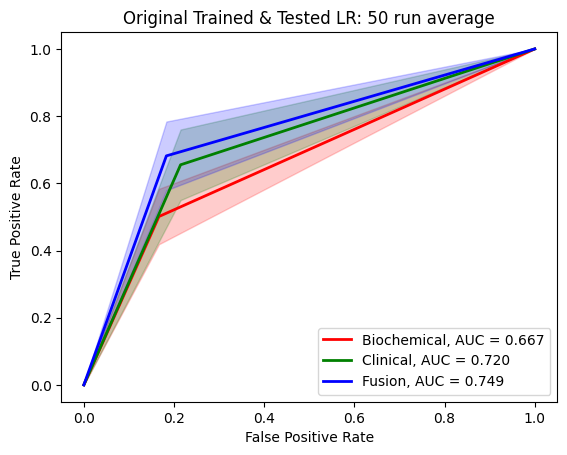

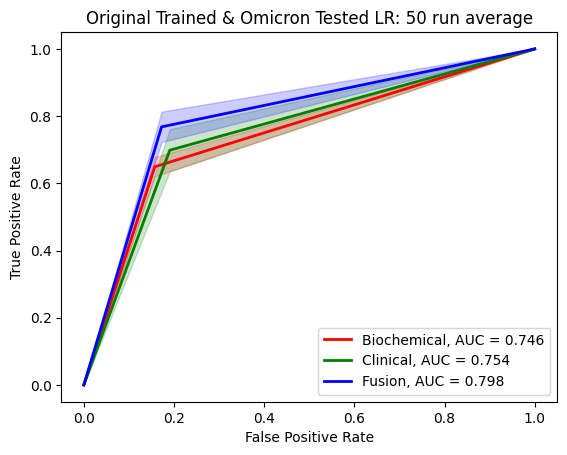

In [ ]:
# ROC Plots---------------------------------------------------------------------
# Plotting the average runs - Original Tested
fig, ax = plt.subplots()
ax.plot(bc_avg_fpr, bc_avg_tpr, label = 'Biochemical, AUC = %.3f'%bc_avg_auc, color='red', linewidth=2)
ax.plot(sy_avg_fpr, sy_avg_tpr, label = 'Clinical, AUC = %.3f'%sy_avg_auc, color='green', linewidth=2)
ax.plot(fn_avg_fpr, fn_avg_tpr, label = 'Fusion, AUC = %.3f'%fn_avg_auc, color='blue', linewidth=2)

# Intervals of 1 Standard Deviation
ax.fill_between(bc_avg_fpr, bc_avg_tpr + bc_std_tpr, bc_avg_tpr - bc_std_tpr, alpha=0.2, color='red')
ax.fill_between(sy_avg_fpr, sy_avg_tpr + sy_std_tpr, sy_avg_tpr - sy_std_tpr, alpha=0.2, color='green')
ax.fill_between(fn_avg_fpr, fn_avg_tpr + fn_std_tpr, fn_avg_tpr - fn_std_tpr, alpha=0.2, color='blue')

plt.title(label='Original Trained & Tested LR: '+str(n_runs)+' run average')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Plotting the average runs - Omicron Tested
fig, ax = plt.subplots()
ax.plot(bc_avg_fpr1, bc_avg_tpr1, label = 'Biochemical, AUC = %.3f'%bc_avg_auc1, color='red', linewidth=2)
ax.plot(sy_avg_fpr1, sy_avg_tpr1, label = 'Clinical, AUC = %.3f'%sy_avg_auc1, color='green', linewidth=2)
ax.plot(fn_avg_fpr1, fn_avg_tpr1, label = 'Fusion, AUC = %.3f'%fn_avg_auc1, color='blue', linewidth=2)

# Intervals of 1 Standard Deviation
ax.fill_between(bc_avg_fpr1, bc_avg_tpr1 + bc_std_tpr1, bc_avg_tpr1 - bc_std_tpr1, alpha=0.2, color='red')
ax.fill_between(sy_avg_fpr1, sy_avg_tpr1 + sy_std_tpr1, sy_avg_tpr1 - sy_std_tpr1, alpha=0.2, color='green')
ax.fill_between(fn_avg_fpr1, fn_avg_tpr1 + fn_std_tpr1, fn_avg_tpr1 - fn_std_tpr1, alpha=0.2, color='blue')

plt.title(label='Original Trained & Omicron Tested LR: '+str(n_runs)+' run average')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Omicron Trained Model


---



#### Hyperparameter Tuning, Training, and Prediction

In [ ]:
# Logistic Regression - Omicron-------------------------------------------------

print('Omicron Data Runs\n')

# Parameter Grid
parameters = {'penalty': (None, 'l1', 'l2')}

# FPR recordings: 1 - TNR, for plotting ROC
bcO_fpr_runs = [] # Omicron trained and tested
syO_fpr_runs = []
fnO_fpr_runs = []

bcO_fpr_runs1 = [] # Omicron trained and original tested
syO_fpr_runs1 = []
fnO_fpr_runs1 = []

# TPR recordings: Sensitivity, Recall
bcO_tpr_runs = [] # Omicron trained and tested
syO_tpr_runs = []
fnO_tpr_runs = []

bcO_tpr_runs1 = [] # Omicron trained and original tested
syO_tpr_runs1 = []
fnO_tpr_runs1 = []
"""
# TNR recordings: Specificity, Sensitivity
bcO_tnr_runs = [] # Omicron Trained and Tested
syO_tnr_runs = []
fnO_tnr_runs = []

bcO_tnr_runs1 = [] # Omicron Trained and original Tested
syO_tnr_runs1 = []
fnO_tnr_runs1 = []
"""
# AUC recordings
bcO_auc_runs = [] # Omicron trained and tested
syO_auc_runs = []
fnO_auc_runs = []

bcO_auc_runs1 = [] # Omicron trained and original tested
syO_auc_runs1 = []
fnO_auc_runs1 = []

# Coefficient recordings
bcO_coeffs = []
syO_coeffs = []
fnO_coeffs = []

# Best parameter recordings
bcO_params = []
syO_params = []
fnO_params = []

for i in range(n_runs):
  j = i+1
  print('Run: ',j,'------------------------------------\n')

  # Train Test Split------------------------------------------------------------
  bioChemO_train, bioChemO_test, bioChemO_labels_train, bioChemO_labels_test = train_test_split(bioChemO_trim, bioChemO_labels, test_size = 1 / 5)
  sympO_train, sympO_test, sympO_labels_train, sympO_labels_test = train_test_split(sympO_trim, sympO_labels, test_size = 1 / 5)
  multiO_train, multiO_test, multiO_labels_train, multiO_labels_test = train_test_split(multiO_trim, multiO_labels, test_size = 1 / 5)

  # Scaling---------------------------------------------------------------------
  # Biochemical Data
  bioChemO_scaler = StandardScaler()
  bioChemO_train = bioChemO_scaler.fit_transform(bioChemO_train)
  bioChemO_test = bioChemO_scaler.transform(bioChemO_test)

  # Clinical Data
  sympO_scaler = StandardScaler()
  sympO_train = sympO_scaler.fit_transform(sympO_train)
  sympO_test = sympO_scaler.transform(sympO_test)

  # Fusion Data
  multiO_scaler = StandardScaler()
  multiO_train = multiO_scaler.fit_transform(multiO_train)
  multiO_test = multiO_scaler.transform(multiO_test)

  # Model Training Grid Search--------------------------------------------------
  bioChemO_LR = LogisticRegression(solver='saga',max_iter=10000)
  bioChemO_clf = GridSearchCV(bioChemO_LR, parameters)
  bioChemO_clf.fit(bioChemO_train, bioChemO_labels_train)

  # Clinical model
  sympO_LR = LogisticRegression(solver='saga',max_iter=10000)
  sympO_clf = GridSearchCV(sympO_LR, parameters)
  sympO_clf.fit(sympO_train, sympO_labels_train)

  # Fusion model
  multiO_LR = LogisticRegression(solver='saga',max_iter=10000)
  multiO_clf = GridSearchCV(multiO_LR, parameters)
  multiO_clf.fit(multiO_train, multiO_labels_train)

  # View results----------------------------------------------------------------
  target_names = ['Non-Severe COVID', 'Severe COVID']

  # Biochemical results---------------------------------------------------------
  print('Biochemical Results\n')

  # Best estimator
  bcO_params.append(bioChemO_clf.best_params_)

  # Top 5 Biochemical features
  bcO_coeffs.append(bioChemO_clf.best_estimator_.coef_[0])

  """feature_importance_1 = pd.DataFrame({'Feature': bioChemO_trim.columns, 'Importance': np.abs(bcO_coeffs)})
  print('Feature ranking for severe COVID-19:', feature_importance_1.nlargest(5, 'Importance', keep='all'))"""

  # Predicting on testing hold-out data
  bioChemO_labels_predict = bioChemO_clf.predict(bioChemO_test)

  # Predicting on original COIVD-19 data
  bioChem_trim_scale = bioChemO_scaler.transform(bioChem_trim)
  bioChem_labels_predict1 = bioChemO_clf.predict(bioChem_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(bioChemO_labels_test, bioChemO_labels_predict)
  bcO_fpr_runs.append(fpr)
  bcO_tpr_runs.append(tpr)

  # Original testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(bioChem_labels, bioChem_labels_predict1)
  bcO_fpr_runs1.append(fpr1)
  bcO_tpr_runs1.append(tpr1)

  # AUC
  BCO_roc_auc = metrics.auc(fpr, tpr)
  bcO_auc_runs.append(BCO_roc_auc)

  # AUC - Original
  BCO_roc_auc1 = metrics.auc(fpr1, tpr1)
  bcO_auc_runs1.append(BCO_roc_auc1)

  # Clinical results---------------------------------------------------------
  print('Clinical Results\n')

  # Best estimator
  syO_params.append(sympO_clf.best_params_)

  # Top 5 Clinical features
  syO_coeffs.append(sympO_clf.best_estimator_.coef_[0])

  """feature_importance_2 = pd.DataFrame({'Feature': sympO_trim.columns, 'Importance': np.abs(syO_coeffs)})
  print('Feature ranking for severe COVID-19:', feature_importance_2.nlargest(5, 'Importance', keep='all'))
"""
  # Predicting on testing hold-out data
  sympO_labels_predict = sympO_clf.predict(sympO_test)

  # Predicting on original COIVD-19 data
  symp_trim_scale = sympO_scaler.transform(symp_trim)
  symp_labels_predict1 = sympO_clf.predict(symp_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(sympO_labels_test, sympO_labels_predict)
  syO_fpr_runs.append(fpr)
  syO_tpr_runs.append(tpr)

  # Original testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(symp_labels, symp_labels_predict1)
  syO_fpr_runs1.append(fpr1)
  syO_tpr_runs1.append(tpr1)

  # AUC
  SYO_roc_auc = metrics.auc(fpr, tpr)
  syO_auc_runs.append(SYO_roc_auc)

  # AUC - Original
  SYO_roc_auc1 = metrics.auc(fpr1, tpr1)
  syO_auc_runs1.append(SYO_roc_auc1)

  # Fusion results--------------------------------------------------------------
  print('Fusion Results\n')

  # Best estimator
  fnO_params.append(multiO_clf.best_params_)

  # Top 5 Fusion features
  fnO_coeffs.append(multiO_clf.best_estimator_.coef_[0])

  """feature_importance_3 = pd.DataFrame({'Feature': multiO_trim.columns, 'Importance': np.abs(fnO_coeffs)})
  print('Feature ranking for severe COVID-19:', feature_importance_3.nlargest(5, 'Importance', keep='all'))"""

  # Predicting on testing hold-out data
  multiO_labels_predict = multiO_clf.predict(multiO_test)

  # Predicting on original COIVD-19 data
  multi_trim_scale = multiO_scaler.transform(multi_trim)
  multi_labels_predict1 = multiO_clf.predict(multi_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(multiO_labels_test, multiO_labels_predict)
  fnO_fpr_runs.append(fpr)
  fnO_tpr_runs.append(tpr)

  # Original testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(multi_labels, multi_labels_predict1)
  fnO_fpr_runs1.append(fpr1)
  fnO_tpr_runs1.append(tpr1)

  # AUC
  FNO_roc_auc = metrics.auc(fpr, tpr)
  fnO_auc_runs.append(FNO_roc_auc)

  # AUC - Original
  FNO_roc_auc1 = metrics.auc(fpr1, tpr1)
  fnO_auc_runs1.append(FNO_roc_auc1)

print(bcO_params)
print(syO_params)
print(fnO_params)

Omicron Data Runs

Run:  1 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  2 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  3 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  4 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  5 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  6 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  7 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  8 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  9 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  10 ------------------------------------

Biochemical Results

Clin

#### Calculating Mean and Standard deviation of metrics

In [ ]:
bcO_avg_fpr, bcO_avg_fpr1, bcO_avg_tpr, bcO_avg_tpr1, bcO_avg_auc, bcO_avg_auc1, bcO_std_fpr, bcO_std_fpr1, bcO_std_tpr, bcO_std_tpr1, bcO_std_auc, bcO_std_auc1 = get_Stats(bcO_fpr_runs,bcO_fpr_runs1,bcO_tpr_runs,bcO_tpr_runs1,bcO_auc_runs,bcO_auc_runs1)
syO_avg_fpr, syO_avg_fpr1, syO_avg_tpr, syO_avg_tpr1, syO_avg_auc, syO_avg_auc1, syO_std_fpr, syO_std_fpr1, syO_std_tpr, syO_std_tpr1, syO_std_auc, syO_std_auc1 = get_Stats(syO_fpr_runs,syO_fpr_runs1,syO_tpr_runs,syO_tpr_runs1,syO_auc_runs,syO_auc_runs1)
fnO_avg_fpr, fnO_avg_fpr1, fnO_avg_tpr, fnO_avg_tpr1, fnO_avg_auc, fnO_avg_auc1, fnO_std_fpr, fnO_std_fpr1, fnO_std_tpr, fnO_std_tpr1, fnO_std_auc, fnO_std_auc1 = get_Stats(fnO_fpr_runs,fnO_fpr_runs1,fnO_tpr_runs,fnO_tpr_runs1,fnO_auc_runs,fnO_auc_runs1)

# Mean coefficients
bcO_mean_coeffs = np.mean(bcO_coeffs, axis=0)
syO_mean_coeffs = np.mean(syO_coeffs, axis=0)
fnO_mean_coeffs = np.mean(fnO_coeffs, axis=0)

#### Printing Stats

In [ ]:
# Printing Results--------------------------------------------------------------
# FPR
print('Mean FPR, original/original, BC: ', bcO_avg_fpr)
print('Mean FPR, original/original, SY: ', syO_avg_fpr)
print('Mean FPR, original/original, FN: ', fnO_avg_fpr)

# FPR - Omicron
print('Mean FPR, original/omicron, BC: ', bcO_avg_fpr1)
print('Mean FPR, original/omicron, SY: ', syO_avg_fpr1)
print('Mean FPR, original/omicron, FN: ', fnO_avg_fpr1)

print('\n')

# TPR
print('Mean TPR, original/original, BC: ', bcO_avg_tpr)
print('Mean TPR, original/original, SY: ', syO_avg_tpr)
print('Mean TPR, original/original, FN: ', fnO_avg_tpr)

# TPR - Omicron
print('Mean TPR, original/omicron, BC: ', bcO_avg_tpr1)
print('Mean TPR, original/omicron, SY: ', syO_avg_tpr1)
print('Mean TPR, original/omicron, FN: ', fnO_avg_tpr1)
"""
print('\n')

# TNR
print('Mean TNR, original/original, BC: ', bc_avg_tnr)
print('Mean TNR, original/original, SY: ', sy_avg_tnr)
print('Mean TNR, original/original, FN: ', fn_avg_tnr)

# TNR - Omicron
print('Mean TNR, original/omicron, BC: ', bc_avg_tnr1)
print('Mean TNR, original/omicron, SY: ', sy_avg_tnr1)
print('Mean TNR, original/omicron, FN: ', fn_avg_tnr1)

print('\n')"""
print('\n')

# AUC
print('AUC of biochem composite ROC curve',metrics.auc(bcO_avg_fpr, bc_avg_tpr))
print('AUC of symp composite ROC curve',metrics.auc(syO_avg_fpr, sy_avg_tpr))
print('AUC of fusion composite ROC curve',metrics.auc(fnO_avg_fpr, fn_avg_tpr))
print('\n')

# AUC - Original
print('AUC of biochem composite ROC curve (Original)',metrics.auc(bcO_avg_fpr1, bc_avg_tpr1))
print('AUC of symp composite ROC curve (Original)',metrics.auc(syO_avg_fpr1, sy_avg_tpr1))
print('AUC of fusion composite ROC curve (Original)',metrics.auc(fnO_avg_fpr1, fn_avg_tpr1))
print('\n')

# AUC
print('AUC STDEV of biochem composite ROC curve',bcO_std_auc)
print('AUC STDEV of symp composite ROC curve',syO_std_auc)
print('AUC STDEV of fusion composite ROC curve',fnO_std_auc)
print('\n')

# AUC - Original
print('AUC STDEV of biochem composite ROC curve (Original)',bcO_std_auc1)
print('AUC STDEV of symp composite ROC curve (Original)',syO_std_auc1)
print('AUC STDEV of fusion composite ROC curve (Original)',fnO_std_auc1)

Mean FPR, original/original, BC:  [0.         0.12921323 1.        ]
Mean FPR, original/original, SY:  [0.         0.18265871 1.        ]
Mean FPR, original/original, FN:  [0.         0.08287725 1.        ]
Mean FPR, original/omicron, BC:  [0.         0.22271028 1.        ]
Mean FPR, original/omicron, SY:  [0.         0.23485981 1.        ]
Mean FPR, original/omicron, FN:  [0.         0.20654206 1.        ]


Mean TPR, original/original, BC:  [0.         0.82713696 1.        ]
Mean TPR, original/original, SY:  [0.         0.81794833 1.        ]
Mean TPR, original/original, FN:  [0.         0.91190807 1.        ]
Mean TPR, original/omicron, BC:  [0.         0.58459459 1.        ]
Mean TPR, original/omicron, SY:  [0.         0.77121622 1.        ]
Mean TPR, original/omicron, FN:  [0.         0.71364865 1.        ]


AUC of biochem composite ROC curve 0.6860032166783812
AUC of symp composite ROC curve 0.7362271027800146
AUC of fusion composite ROC curve 0.7994152638995596


AUC of biochem

#### Displaying ROC Plots and AUC



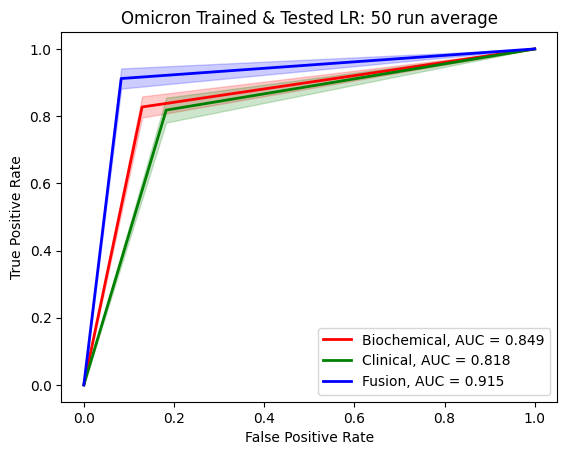

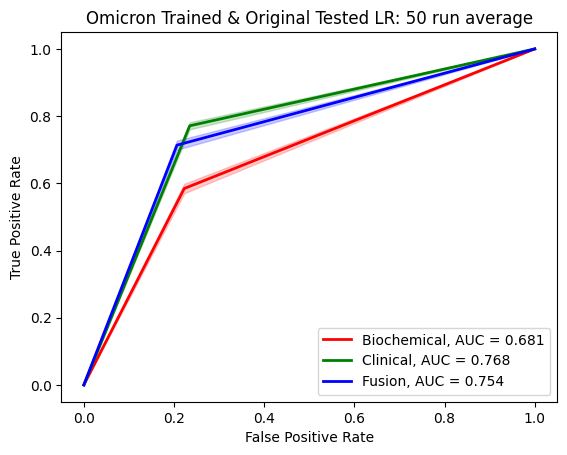

In [ ]:
# ROC Plots---------------------------------------------------------------------
# Plotting the average runs - Omicron Tested
fig, ax = plt.subplots()
ax.plot(bcO_avg_fpr, bcO_avg_tpr, label = 'Biochemical, AUC = %.3f'%bcO_avg_auc, color='red', linewidth=2)
ax.plot(syO_avg_fpr, syO_avg_tpr, label = 'Clinical, AUC = %.3f'%syO_avg_auc, color='green', linewidth=2)
ax.plot(fnO_avg_fpr, fnO_avg_tpr, label = 'Fusion, AUC = %.3f'%fnO_avg_auc, color='blue', linewidth=2)

# Intervals of 1 Standard Deviation
ax.fill_between(bcO_avg_fpr, bcO_avg_tpr + bcO_std_tpr, bcO_avg_tpr - bcO_std_tpr, alpha=0.2, color='red')
ax.fill_between(syO_avg_fpr, syO_avg_tpr + syO_std_tpr, syO_avg_tpr - syO_std_tpr, alpha=0.2, color='green')
ax.fill_between(fnO_avg_fpr, fnO_avg_tpr + fnO_std_tpr, fnO_avg_tpr - fnO_std_tpr, alpha=0.2, color='blue')

plt.title(label='Omicron Trained & Tested LR: '+str(n_runs)+' run average')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Plotting the average runs - Original Tested
fig, ax = plt.subplots()
ax.plot(bcO_avg_fpr1, bcO_avg_tpr1, label = 'Biochemical, AUC = %.3f'%bcO_avg_auc1, color='red', linewidth=2)
ax.plot(syO_avg_fpr1, syO_avg_tpr1, label = 'Clinical, AUC = %.3f'%syO_avg_auc1, color='green', linewidth=2)
ax.plot(fnO_avg_fpr1, fnO_avg_tpr1, label = 'Fusion, AUC = %.3f'%fnO_avg_auc1, color='blue', linewidth=2)

# Intervals of 1 Standard Deviation
ax.fill_between(bcO_avg_fpr1, bcO_avg_tpr1 + bcO_std_tpr1, bcO_avg_tpr1 - bcO_std_tpr1, alpha=0.2, color='red')
ax.fill_between(syO_avg_fpr1, syO_avg_tpr1 + syO_std_tpr1, syO_avg_tpr1 - syO_std_tpr1, alpha=0.2, color='green')
ax.fill_between(fnO_avg_fpr1, fnO_avg_tpr1 + fnO_std_tpr1, fnO_avg_tpr1 - fnO_std_tpr1, alpha=0.2, color='blue')

plt.title(label='Omicron Trained & Original Tested LR: '+str(n_runs)+' run average')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Feature Importance

Text(0.5, 1.0, 'Omicron (Fusion) Trained Logistic Regression Ranked Features: 50 run average')

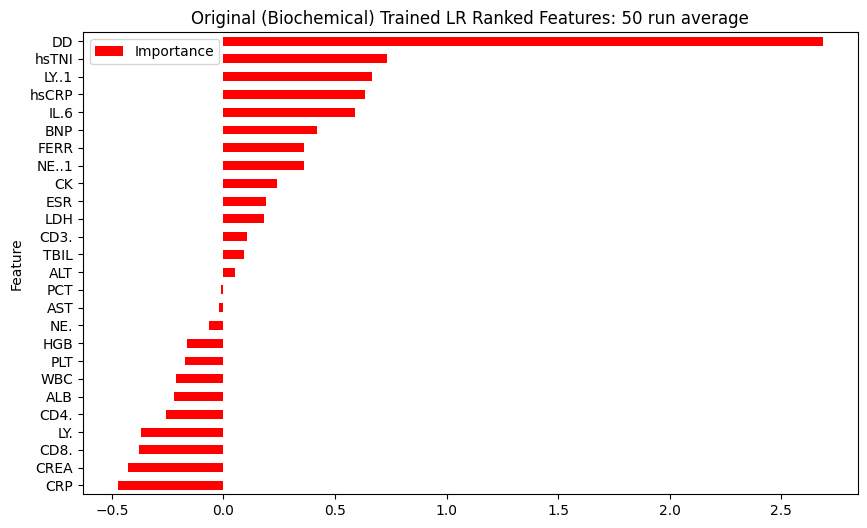

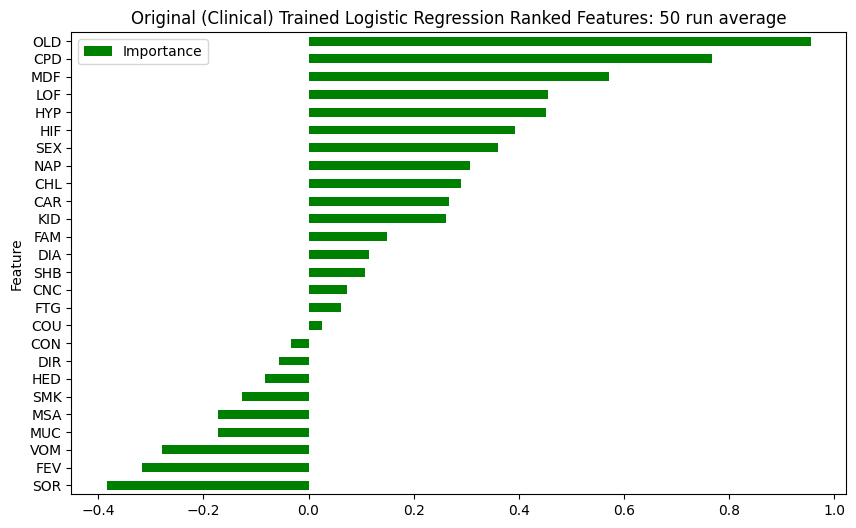

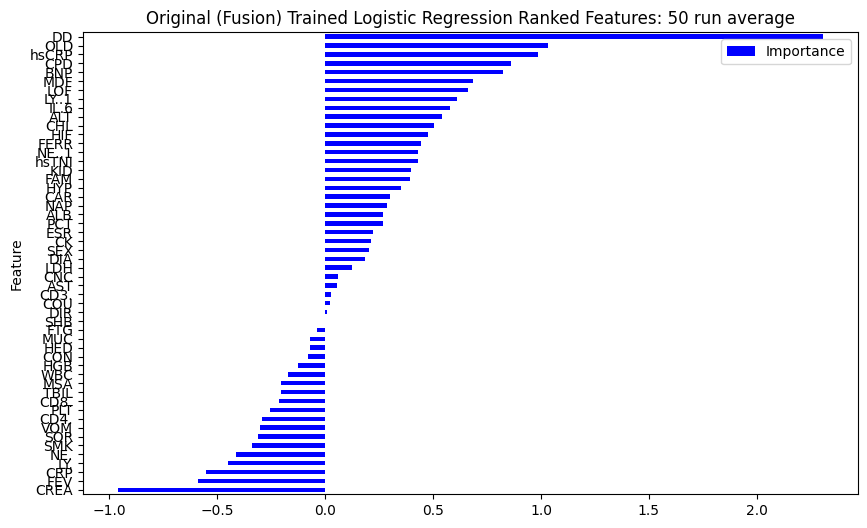

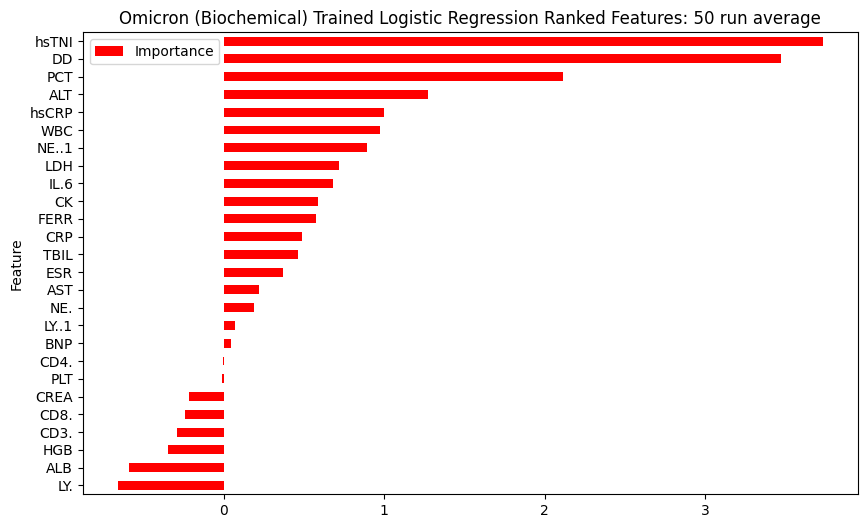

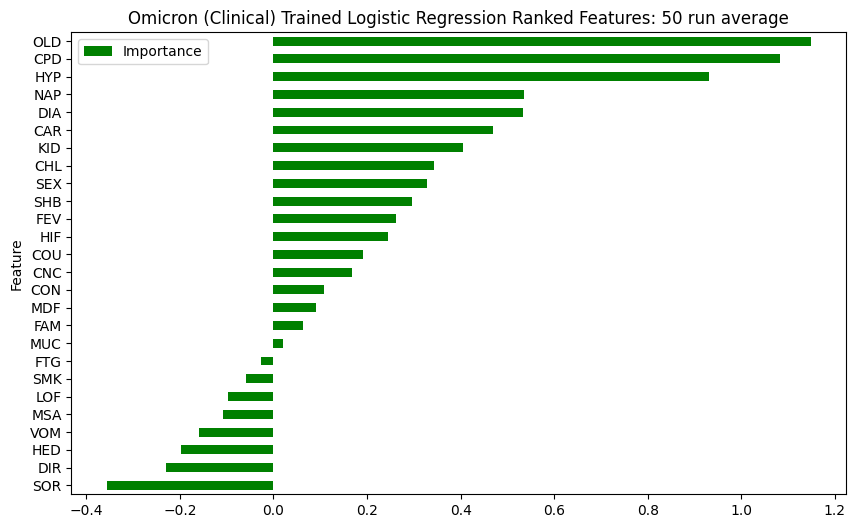

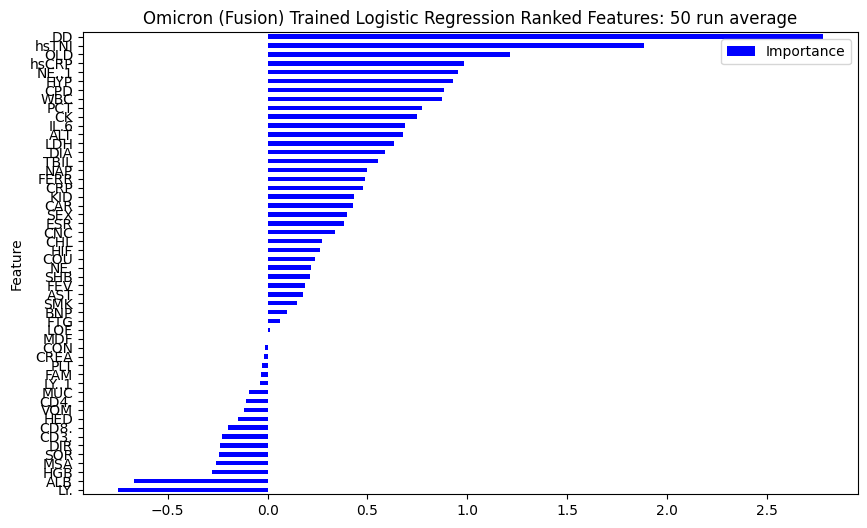

In [ ]:
# Original COVID-19 Data--------------------------------------------------------

# Best Coefficients of Biochemical Models
feature_importance = pd.DataFrame({'Feature': bioChem_trim.columns, 'Importance': bc_mean_coeffs})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', color='red', figsize=(10, 6))
plt.title(label='Original (Biochemical) Trained LR Ranked Features: '+str(n_runs)+' run average')

# Best Coefficients of Clinical Models
feature_importance = pd.DataFrame({'Feature': symp_trim.columns, 'Importance': sy_mean_coeffs})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', color='green', figsize=(10, 6))
plt.title(label='Original (Clinical) Trained Logistic Regression Ranked Features: '+str(n_runs)+' run average')

# Best Coefficients of Fusion Models
fn_coeffs = multi_clf.best_estimator_.coef_[0]

feature_importance = pd.DataFrame({'Feature': multi_trim.columns, 'Importance': fn_mean_coeffs})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', color='blue', figsize=(10, 6))
plt.title(label='Original (Fusion) Trained Logistic Regression Ranked Features: '+str(n_runs)+' run average')

# Omicron COVID-19 Data--------------------------------------------------------

# Best Coefficients of Biochemical Models
feature_importance = pd.DataFrame({'Feature': bioChemO_trim.columns, 'Importance': bcO_mean_coeffs})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', color='red', figsize=(10, 6))
plt.title(label='Omicron (Biochemical) Trained Logistic Regression Ranked Features: '+str(n_runs)+' run average')

# Best Coefficients of Clinical Models
feature_importance = pd.DataFrame({'Feature': sympO_trim.columns, 'Importance': syO_mean_coeffs})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', color='green', figsize=(10, 6))
plt.title(label='Omicron (Clinical) Trained Logistic Regression Ranked Features: '+str(n_runs)+' run average')

# Best Coefficients of Fusion Models
feature_importance = pd.DataFrame({'Feature': multiO_trim.columns, 'Importance': fnO_mean_coeffs})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', color='blue', figsize=(10, 6))
plt.title(label='Omicron (Fusion) Trained Logistic Regression Ranked Features: '+str(n_runs)+' run average')

## Random Forest



### Original Trained Model

---



#### Hyperparameter Tuning, Training, and Prediction



In [ ]:
# Random Forest - Original------------------------------------------------------

print('Original Data Runs\n')

# Parameter Grid
tree_range = list(range(1,10))
depth_range = list(range(1,10))
parameters = {'n_estimators': tree_range, 'criterion':('gini', 'entropy', 'log_loss'), 'max_depth': depth_range}

# FPR recordings: 1-TNR, for plotting AUC
bc_fpr_runs = [] # Original Trained and Tested
sy_fpr_runs = []
fn_fpr_runs = []

bc_fpr_runs1 = [] # Original Trained and Omicron Tested
sy_fpr_runs1 = []
fn_fpr_runs1 = []

# TPR recordings: Sensitivity, Recall
bc_tpr_runs = [] # Original Trained and Tested
sy_tpr_runs = []
fn_tpr_runs = []

bc_tpr_runs1 = [] # Original Trained and Omicron Tested
sy_tpr_runs1 = []
fn_tpr_runs1 = []
"""
# TNR recordings: Specificity, Sensitivity
bc_tnr_runs = [] # Original Trained and Tested
sy_tnr_runs = []
fn_tnr_runs = []

bc_tnr_runs1 = [] # Original Trained and Omicron Tested
sy_tnr_runs1 = []
fn_tnr_runs1 = []
"""
# AUC recordings
bc_auc_runs = [] # Original Trained and Tested
sy_auc_runs = []
fn_auc_runs = []

bc_auc_runs1 = [] # Original Trained and Omicron Tested
sy_auc_runs1 = []
fn_auc_runs1 = []

# Coefficient recordings
bc_coeffs = []
sy_coeffs = []
fn_coeffs = []

# Best parameter recordings
bc_params = []
sy_params = []
fn_params = []

for i in range(n_runs):
  j = i+1
  print('Run: ',j,'------------------------------------\n')

  # Train Test Split------------------------------------------------------------
  bioChem_train, bioChem_test, bioChem_labels_train, bioChem_labels_test = train_test_split(bioChem_trim, bioChem_labels, test_size = 1 / 5)
  symp_train, symp_test, symp_labels_train, symp_labels_test = train_test_split(symp_trim, symp_labels, test_size = 1 / 5)
  multi_train, multi_test, multi_labels_train, multi_labels_test = train_test_split(multi_trim, multi_labels, test_size = 1 / 5)

  # Scaling---------------------------------------------------------------------
  # Biochemical Data
  bioChem_scaler = StandardScaler()
  bioChem_train = bioChem_scaler.fit_transform(bioChem_train)
  bioChem_test = bioChem_scaler.transform(bioChem_test)

  # Clinical Data
  symp_scaler = StandardScaler()
  symp_train = symp_scaler.fit_transform(symp_train)
  symp_test = symp_scaler.transform(symp_test)

  # Fusion Data
  multi_scaler = StandardScaler()
  multi_train = multi_scaler.fit_transform(multi_train)
  multi_test = multi_scaler.transform(multi_test)

  # Model Training Grid Search--------------------------------------------------
  # Biochemical model
  bioChem_RF = RandomForestClassifier()
  bioChem_clf = GridSearchCV(bioChem_RF, parameters)
  bioChem_clf.fit(bioChem_train, bioChem_labels_train)

  # Clinical model
  symp_RF = RandomForestClassifier()
  symp_clf = GridSearchCV(symp_RF, parameters)
  symp_clf.fit(symp_train, symp_labels_train)

  # Fusion model
  multi_RF = RandomForestClassifier()
  multi_clf = GridSearchCV(multi_RF, parameters)
  multi_clf.fit(multi_train, multi_labels_train)

  # View results----------------------------------------------------------------
  target_names = ['Non-Severe COVID', 'Severe COVID']

  # Biochemical results---------------------------------------------------------
  print('Biochemical Results\n')

  # Best estimator
  bc_params.append(bioChem_clf.best_params_)

  # Top Biochemical features
  # Random Forest Impurity Rankings
  bc_coeffs.append(bioChem_clf.best_estimator_.feature_importances_)

  """feature_importance_1 = pd.DataFrame({'Feature': bioChem_trim.columns, 'Importance': np.abs(bc_coeffs)})
  print('Feature ranking for severe COVID-19:\n', feature_importance_1.nlargest(5, 'Importance', keep='all'))"""

  """# Trees feature importance from Mean Decrease in Impurity (MDI)
  per_imp_bc = permutation_importance(bioChem_clf.best_estimator_, bioChem_test, bioChem_labels_test)
  sorted_imp_bc = per_imp_bc.importances_mean.argsort()
  importances1 = pd.DataFrame(per_imp_bc.importances[sorted_imp_bc].T, columns = bioChem_trim.columns[sorted_imp_bc])

  ax = importances1.plot.box(vert=False, whis=10)
  ax.set_title(" Original (Biochemical) Permutation Importances (Original Tested)")
  ax.axvline(x=0, color="k", linestyle="--")
  ax.set_xlabel("Decrease in accuracy score")
  ax.figure.tight_layout()"""

  # Predicting on testing hold-out data
  bioChem_labels_predict = bioChem_clf.predict(bioChem_test)

  # Predicting on Omicron Data
  bioChemO_trim_scale = bioChem_scaler.transform(bioChemO_trim)
  bioChemO_labels_predict = bioChem_clf.predict(bioChemO_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(bioChem_labels_test, bioChem_labels_predict)
  bc_fpr_runs.append(fpr)
  bc_tpr_runs.append(tpr)

  # Omicron testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(bioChemO_labels, bioChemO_labels_predict)
  bc_fpr_runs1.append(fpr1)
  bc_tpr_runs1.append(tpr1)

  # AUC
  BC_roc_auc = metrics.auc(fpr, tpr)
  bc_auc_runs.append(BC_roc_auc)

  # AUC - Omicron
  BC_roc_auc1 = metrics.auc(fpr1, tpr1)
  bc_auc_runs1.append(BC_roc_auc1)

  # Clinical results------------------------------------------------------------
  print('\nClinical Results\n')

  # Best estimator
  sy_params.append(symp_clf.best_params_)

  # Top Clinical features
  # Random Forest Impurity Rankings
  sy_coeffs.append(symp_clf.best_estimator_.feature_importances_)

  """feature_importance_2 = pd.DataFrame({'Feature': symp_trim.columns, 'Importance': np.abs(sy_coeffs)})
  print('Feature ranking for severe COVID-19:\n', feature_importance_2.nlargest(5, 'Importance', keep='all'))

  # Trees feature importance from Mean Decrease in Impurity (MDI)
  per_imp_sy = permutation_importance(symp_clf.best_estimator_, symp_test, symp_labels_test)
  sorted_imp_sy = per_imp_sy.importances_mean.argsort()
  importances2 = pd.DataFrame(per_imp_sy.importances[sorted_imp_sy].T, columns = symp_trim.columns[sorted_imp_sy])

  ax = importances2.plot.box(vert=False, whis=10)
  ax.set_title(" Original (Clinical) Permutation Importances (Original Tested)")
  ax.axvline(x=0, color="k", linestyle="--")
  ax.set_xlabel("Decrease in accuracy score")
  ax.figure.tight_layout()"""

  # Predicting on testing hold-out data
  symp_labels_predict = symp_clf.predict(symp_test)

  # Predicting on Omicron Data
  sympO_trim_scale = symp_scaler.transform(sympO_trim)
  sympO_labels_predict = symp_clf.predict(sympO_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(symp_labels_test, symp_labels_predict)
  sy_fpr_runs.append(fpr)
  sy_tpr_runs.append(tpr)

  # Omicron testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(sympO_labels,sympO_labels_predict)
  sy_fpr_runs1.append(fpr1)
  sy_tpr_runs1.append(tpr1)

  # AUC
  SY_roc_auc = metrics.auc(fpr, tpr)
  sy_auc_runs.append(SY_roc_auc)

  # AUC - Omicron
  SY_roc_auc1 = metrics.auc(fpr1, tpr1)
  sy_auc_runs1.append(SY_roc_auc1)

  # Fusion results--------------------------------------------------------------
  print('\nFusion Results\n')

  # Best estimator
  fn_params.append(multi_clf.best_params_)

  # Top Fusion features
  # Random Forest Impurity Rankings
  fn_coeffs.append(multi_clf.best_estimator_.feature_importances_)

  """feature_importance_3 = pd.DataFrame({'Feature': multi_trim.columns, 'Importance': np.abs(fn_coeffs)})
  print('Feature ranking for severe COVID-19:\n', feature_importance_3.nlargest(5, 'Importance', keep='all'))

  # Trees feature importance from Mean Decrease in Impurity (MDI)
  per_imp_fn = permutation_importance(multi_clf.best_estimator_, multi_test, multi_labels_test)
  sorted_imp_fn = per_imp_fn.importances_mean.argsort()
  importances3 = pd.DataFrame(per_imp_fn.importances[sorted_imp_fn].T, columns = multi_trim.columns[sorted_imp_fn])

  ax = importances3.plot.box(vert=False, whis=10)
  ax.set_title(" Original (Fusion) Permutation Importances (Original Tested)")
  ax.axvline(x=0, color="k", linestyle="--")
  ax.set_xlabel("Decrease in accuracy score")
  ax.figure.tight_layout()"""

  # Predicting on testing hold-out data
  multi_labels_predict = multi_clf.predict(multi_test)

  # Predicting on Omicron Data
  multiO_trim_scale = multi_scaler.transform(multiO_trim)
  multiO_labels_predict = multi_clf.predict(multiO_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(multi_labels_test, multi_labels_predict)
  fn_fpr_runs.append(fpr)
  fn_tpr_runs.append(tpr)

  # Omicron testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(multiO_labels, multiO_labels_predict)
  fn_fpr_runs1.append(fpr1)
  fn_tpr_runs1.append(tpr1)

  # AUC
  FN_roc_auc = metrics.auc(fpr, tpr)
  fn_auc_runs.append(FN_roc_auc)

  # AUC - Omicron
  FN_roc_auc1 = metrics.auc(fpr1, tpr1)
  fn_auc_runs1.append(FN_roc_auc1)

print(bc_params)
print(sy_params)
print(fn_params)

Original Data Runs

Run:  1 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  2 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  3 ------------------------------------

Biochemical Results


Clinical Results


Fusion Results

Run:  4 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  5 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  6 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  7 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  8 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  9 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  10 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  11 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  12 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  13 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  14 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  15 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  16 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  17 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  18 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  19 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  20 ------------------------------------

Biochemical Results


Clinical Results


Fusion Results

Run:  21 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  22 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  23 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  24 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  25 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  26 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  27 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  28 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  29 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  30 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  31 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  32 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  33 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  34 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  35 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  36 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  37 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  38 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  39 ------------------------------------

Biochemical Results


Clinical Results


Fusion Results

Run:  40 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  41 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  42 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  43 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  44 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  45 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  46 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  47 ------------------------------------

Biochemical Results


Clinical Results


Fusion Results

Run:  48 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

Run:  49 ------------------------------------

Biochemical Results


Clinical Results


Fusion Results

Run:  50 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results


Clinical Results


Fusion Results

[{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 8}, {'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 6}, {'criterion': 'log_loss', 'max_depth': 6, 'n_estimators': 5}, {'criterion': 'log_loss', 'max_depth': 5, 'n_estimators': 5}, {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 7}, {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 9}, {'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 7}, {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 7}, {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 9}, {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 5}, {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 4}, {'criterion': 'log_loss', 'max_depth': 4, 'n_estimators': 9}, {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 9}, {'criterion': 'log_loss', 'max_depth': 5, 'n_estimators': 8}, {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 9}, {'criterion': 'log_loss', 'ma

#### Calculating Mean and Standard deviation of metrics

In [ ]:
bc_avg_fpr, bc_avg_fpr1, bc_avg_tpr, bc_avg_tpr1, bc_avg_auc, bc_avg_auc1, bc_std_fpr, bc_std_fpr1, bc_std_tpr, bc_std_tpr1, bc_std_auc, bc_std_auc1 = get_Stats(bc_fpr_runs,bc_fpr_runs1,bc_tpr_runs,bc_tpr_runs1,bc_auc_runs,bc_auc_runs1)
sy_avg_fpr, sy_avg_fpr1, sy_avg_tpr, sy_avg_tpr1, sy_avg_auc, sy_avg_auc1, sy_std_fpr, sy_std_fpr1, sy_std_tpr, sy_std_tpr1, sy_std_auc, sy_std_auc1 = get_Stats(sy_fpr_runs,sy_fpr_runs1,sy_tpr_runs,sy_tpr_runs1,sy_auc_runs,sy_auc_runs1)
fn_avg_fpr, fn_avg_fpr1, fn_avg_tpr, fn_avg_tpr1, fn_avg_auc, fn_avg_auc1, fn_std_fpr, fn_std_fpr1, fn_std_tpr, fn_std_tpr1, fn_std_auc, fn_std_auc1 = get_Stats(fn_fpr_runs,fn_fpr_runs1,fn_tpr_runs,fn_tpr_runs1,fn_auc_runs,fn_auc_runs1)

# Mean coefficients
bc_mean_coeffs = np.mean(bc_coeffs, axis=0)
sy_mean_coeffs = np.mean(sy_coeffs, axis=0)
fn_mean_coeffs = np.mean(fn_coeffs, axis=0)

#### Printing Stats

In [ ]:
# Printing Results--------------------------------------------------------------
# FPR
print('Mean FPR, original/original, BC: ', bc_avg_fpr)
print('Mean FPR, original/original, SY: ', sy_avg_fpr)
print('Mean FPR, original/original, FN: ', fn_avg_fpr)

# FPR - Omicron
print('Mean FPR, original/omicron, BC: ', bc_avg_fpr1)
print('Mean FPR, original/omicron, SY: ', sy_avg_fpr1)
print('Mean FPR, original/omicron, FN: ', fn_avg_fpr1)

print('\n')

# TPR
print('Mean TPR, original/original, BC: ', bc_avg_tpr)
print('Mean TPR, original/original, SY: ', sy_avg_tpr)
print('Mean TPR, original/original, FN: ', fn_avg_tpr)

# TPR - Omicron
print('Mean TPR, original/omicron, BC: ', bc_avg_tpr1)
print('Mean TPR, original/omicron, SY: ', sy_avg_tpr1)
print('Mean TPR, original/omicron, FN: ', fn_avg_tpr1)
"""
print('\n')

# TNR
print('Mean TNR, original/original, BC: ', bc_avg_tnr)
print('Mean TNR, original/original, SY: ', sy_avg_tnr)
print('Mean TNR, original/original, FN: ', fn_avg_tnr)

# TNR - Omicron
print('Mean TNR, original/omicron, BC: ', bc_avg_tnr1)
print('Mean TNR, original/omicron, SY: ', sy_avg_tnr1)
print('Mean TNR, original/omicron, FN: ', fn_avg_tnr1)

print('\n')"""
print('\n')

# AUC
print('AUC of biochem composite ROC curve',metrics.auc(bc_avg_fpr, bc_avg_tpr))
print('AUC of symp composite ROC curve',metrics.auc(sy_avg_fpr, sy_avg_tpr))
print('AUC of fusion composite ROC curve',metrics.auc(fn_avg_fpr, fn_avg_tpr))
print('\n')

# AUC - Omicron
print('AUC of biochem composite ROC curve (Omicron)',metrics.auc(bc_avg_fpr1, bc_avg_tpr1))
print('AUC of symp composite ROC curve (Omicron)',metrics.auc(sy_avg_fpr1, sy_avg_tpr1))
print('AUC of fusion composite ROC curve (Omicron)',metrics.auc(fn_avg_fpr1, fn_avg_tpr1))
print('\n')

# AUC
print('AUC STDEV of biochem composite ROC curve',bc_std_auc)
print('AUC STDEV of symp composite ROC curve',sy_std_auc)
print('AUC STDEV of fusion composite ROC curve',fn_std_auc)
print('\n')

# AUC - Omicron
print('AUC STDEV of biochem composite ROC curve (Omicron)',bc_std_auc1)
print('AUC STDEV of symp composite ROC curve (Omicron)',sy_std_auc1)
print('AUC STDEV of fusion composite ROC curve (Omicron)',fn_std_auc1)

Mean FPR, original/original, BC:  [0.         0.18576307 1.        ]
Mean FPR, original/original, SY:  [0.         0.20131869 1.        ]
Mean FPR, original/original, FN:  [0.        0.1805321 1.       ]
Mean FPR, original/omicron, BC:  [0.     0.1024 1.    ]
Mean FPR, original/omicron, SY:  [0.      0.15436 1.     ]
Mean FPR, original/omicron, FN:  [0.      0.09008 1.     ]


Mean TPR, original/original, BC:  [0.        0.5415795 1.       ]
Mean TPR, original/original, SY:  [0.         0.61681998 1.        ]
Mean TPR, original/original, FN:  [0.         0.57470854 1.        ]
Mean TPR, original/omicron, BC:  [0.    0.656 1.   ]
Mean TPR, original/omicron, SY:  [0.      0.64564 1.     ]
Mean TPR, original/omicron, FN:  [0.      0.70856 1.     ]


AUC of biochem composite ROC curve 0.6779082170630798
AUC of symp composite ROC curve 0.7077506405691634
AUC of fusion composite ROC curve 0.6970882197739693


AUC of biochem composite ROC curve (Omicron) 0.7767999999999999
AUC of symp composi

#### Displaying ROC Plots and AUC



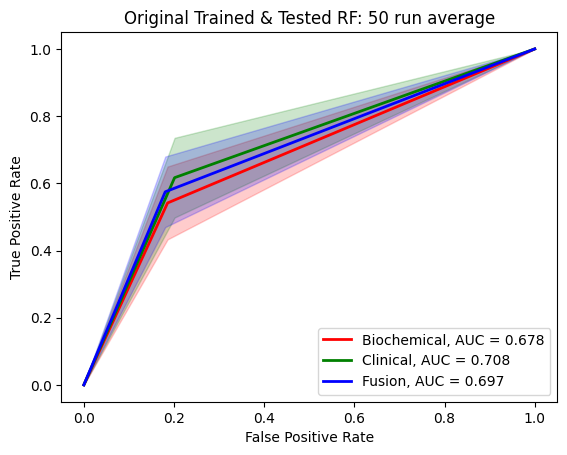

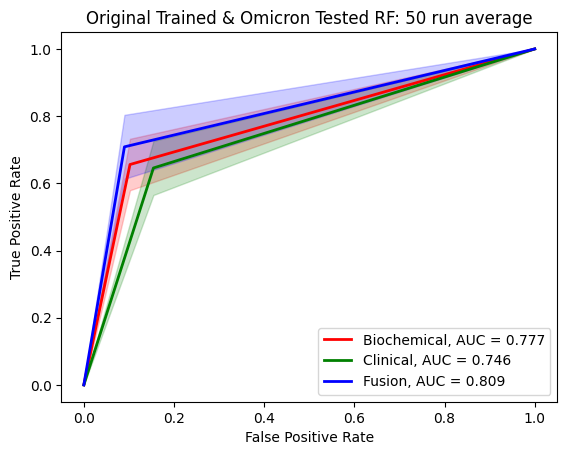

In [ ]:
# ROC Plots---------------------------------------------------------------------
# Plotting the average runs - Original Tested
fig, ax = plt.subplots()
ax.plot(bc_avg_fpr, bc_avg_tpr, label = 'Biochemical, AUC = %.3f'%bc_avg_auc, color='red', linewidth=2)
ax.plot(sy_avg_fpr, sy_avg_tpr, label = 'Clinical, AUC = %.3f'%sy_avg_auc, color='green', linewidth=2)
ax.plot(fn_avg_fpr, fn_avg_tpr, label = 'Fusion, AUC = %.3f'%fn_avg_auc, color='blue', linewidth=2)

# Intervals of 1 Standard Deviation
ax.fill_between(bc_avg_fpr, bc_avg_tpr + bc_std_tpr, bc_avg_tpr - bc_std_tpr, alpha=0.2, color='red')
ax.fill_between(sy_avg_fpr, sy_avg_tpr + sy_std_tpr, sy_avg_tpr - sy_std_tpr, alpha=0.2, color='green')
ax.fill_between(fn_avg_fpr, fn_avg_tpr + fn_std_tpr, fn_avg_tpr - fn_std_tpr, alpha=0.2, color='blue')

plt.title(label='Original Trained & Tested RF: '+str(n_runs)+' run average')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Plotting the average runs - Omicron Tested
fig, ax = plt.subplots()
ax.plot(bc_avg_fpr1, bc_avg_tpr1, label = 'Biochemical, AUC = %.3f'%bc_avg_auc1, color='red', linewidth=2)
ax.plot(sy_avg_fpr1, sy_avg_tpr1, label = 'Clinical, AUC = %.3f'%sy_avg_auc1, color='green', linewidth=2)
ax.plot(fn_avg_fpr1, fn_avg_tpr1, label = 'Fusion, AUC = %.3f'%fn_avg_auc1, color='blue', linewidth=2)

# Intervals of 1 Standard Deviation
ax.fill_between(bc_avg_fpr1, bc_avg_tpr1 + bc_std_tpr1, bc_avg_tpr1 - bc_std_tpr1, alpha=0.2, color='red')
ax.fill_between(sy_avg_fpr1, sy_avg_tpr1 + sy_std_tpr1, sy_avg_tpr1 - sy_std_tpr1, alpha=0.2, color='green')
ax.fill_between(fn_avg_fpr1, fn_avg_tpr1 + fn_std_tpr1, fn_avg_tpr1 - fn_std_tpr1, alpha=0.2, color='blue')

plt.title(label='Original Trained & Omicron Tested RF: '+str(n_runs)+' run average')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Omicron Trained Model

---



#### Hyperparameter Tuning, Training, and Prediction

In [ ]:
# Random Forest - Omicron-------------------------------------------------------

print('Omicron Data Runs\n')

# Parameter Grid
tree_range = list(range(1,10))
depth_range = list(range(1,10))
parameters = {'n_estimators': tree_range, 'criterion':('gini', 'entropy', 'log_loss'), 'max_depth': depth_range}

# FPR recordings: 1 - TNR, for plotting ROC
bcO_fpr_runs = [] # Omicron trained and tested
syO_fpr_runs = []
fnO_fpr_runs = []

bcO_fpr_runs1 = [] # Omicron trained and original tested
syO_fpr_runs1 = []
fnO_fpr_runs1 = []

# TPR recordings: Sensitivity, Recall
bcO_tpr_runs = [] # Omicron trained and tested
syO_tpr_runs = []
fnO_tpr_runs = []

bcO_tpr_runs1 = [] # Omicron trained and original tested
syO_tpr_runs1 = []
fnO_tpr_runs1 = []
"""
# TNR recordings: Specificity, Sensitivity
bcO_tnr_runs = [] # Omicron Trained and Tested
syO_tnr_runs = []
fnO_tnr_runs = []

bcO_tnr_runs1 = [] # Omicron Trained and original Tested
syO_tnr_runs1 = []
fnO_tnr_runs1 = []
"""
# AUC recordings
bcO_auc_runs = [] # Omicron trained and tested
syO_auc_runs = []
fnO_auc_runs = []

bcO_auc_runs1 = [] # Omicron trained and original tested
syO_auc_runs1 = []
fnO_auc_runs1 = []

# Coefficient recordings
bcO_coeffs = []
syO_coeffs = []
fnO_coeffs = []

# Best parameter recordings
bcO_params = []
syO_params = []
fnO_params = []

for i in range(n_runs):
  j = i+1
  print('Run: ',j,'------------------------------------\n')

  # Train Test Split------------------------------------------------------------
  bioChemO_train, bioChemO_test, bioChemO_labels_train, bioChemO_labels_test = train_test_split(bioChemO_trim, bioChemO_labels, test_size = 1 / 5)
  sympO_train, sympO_test, sympO_labels_train, sympO_labels_test = train_test_split(sympO_trim, sympO_labels, test_size = 1 / 5)
  multiO_train, multiO_test, multiO_labels_train, multiO_labels_test = train_test_split(multiO_trim, multiO_labels, test_size = 1 / 5)

  # Scaling---------------------------------------------------------------------
  # Biochemical Data
  bioChemO_scaler = StandardScaler()
  bioChemO_train = bioChemO_scaler.fit_transform(bioChemO_train)
  bioChemO_test = bioChemO_scaler.transform(bioChemO_test)

  # Clinical Data
  sympO_scaler = StandardScaler()
  sympO_train = sympO_scaler.fit_transform(sympO_train)
  sympO_test = sympO_scaler.transform(sympO_test)

  # Fusion Data
  multiO_scaler = StandardScaler()
  multiO_train = multiO_scaler.fit_transform(multiO_train)
  multiO_test = multiO_scaler.transform(multiO_test)

   # Model Training Grid Search--------------------------------------------------
  bioChemO_RF = RandomForestClassifier()
  bioChemO_clf = GridSearchCV(bioChemO_RF, parameters)
  bioChemO_clf.fit(bioChemO_train, bioChemO_labels_train)

  # Clinical model
  sympO_RF = RandomForestClassifier()
  sympO_clf = GridSearchCV(sympO_RF, parameters)
  sympO_clf.fit(sympO_train, sympO_labels_train)

  # Fusion model
  multiO_RF = RandomForestClassifier()
  multiO_clf = GridSearchCV(multiO_RF, parameters)
  multiO_clf.fit(multiO_train, multiO_labels_train)

  # View results----------------------------------------------------------------
  target_names = ['Non-Severe COVID', 'Severe COVID']

  # Biochemical results---------------------------------------------------------
  #print('Biochemical Results\n')

  # Best estimator
  bcO_params.append(bioChemO_clf.best_params_)

  # Feature Ranking
  # Random Forest Impurity Rankings
  bcO_coeffs.append(bioChemO_clf.best_estimator_.feature_importances_)

  """feature_importance_1 = pd.DataFrame({'Feature': bioChemO_trim.columns, 'Importance': np.abs(bcO_coeffs)})
  print('Feature ranking for severe COVID-19:', feature_importance_1.nlargest(5, 'Importance', keep='all'))

  # Trees feature importance from Mean Decrease in Impurity (MDI) {not adapted for omicron}
  per_imp_bc = permutation_importance(bioChem_clf.best_estimator_, bioChem_test, bioChem_labels_test)
  sorted_imp_bc = per_imp_bc.importances_mean.argsort()
  importances1 = pd.DataFrame(per_imp_bc.importances[sorted_imp_bc].T, columns = bioChem_trim.columns[sorted_imp_bc])

  ax = importances1.plot.box(vert=False, whis=10)
  ax.set_title(" Original (Biochemical) Permutation Importances (Original Tested)")
  ax.axvline(x=0, color="k", linestyle="--")
  ax.set_xlabel("Decrease in accuracy score")
  ax.figure.tight_layout()"""

  # Predicting on testing hold-out data
  bioChemO_labels_predict = bioChemO_clf.predict(bioChemO_test)

  # Predicting on original COIVD-19 data
  bioChem_trim_scale = bioChemO_scaler.transform(bioChem_trim)
  bioChem_labels_predict1 = bioChemO_clf.predict(bioChem_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(bioChemO_labels_test, bioChemO_labels_predict)
  bcO_fpr_runs.append(fpr)
  bcO_tpr_runs.append(tpr)

  # Original testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(bioChem_labels, bioChem_labels_predict1)
  bcO_fpr_runs1.append(fpr1)
  bcO_tpr_runs1.append(tpr1)

  # AUC
  BCO_roc_auc = metrics.auc(fpr, tpr)
  bcO_auc_runs.append(BCO_roc_auc)

  # AUC - Original
  BCO_roc_auc1 = metrics.auc(fpr1, tpr1)
  bcO_auc_runs1.append(BCO_roc_auc1)

  # Clinical results---------------------------------------------------------
  #print('Clinical Results\n')

  # Best estimator
  syO_params.append(sympO_clf.best_params_)

  # Top 5 Clinical features
  # Random Forest Impurity Rankings
  syO_coeffs.append(sympO_clf.best_estimator_.feature_importances_)

  """feature_importance_2 = pd.DataFrame({'Feature': sympO_trim.columns, 'Importance': np.abs(syO_coeffs)})
  print('Feature ranking for severe COVID-19:', feature_importance_2.nlargest(5, 'Importance', keep='all'))

  # Trees feature importance from Mean Decrease in Impurity (MDI) {not adapted for Omicron}
  per_imp_sy = permutation_importance(symp_clf.best_estimator_, symp_test, symp_labels_test)
  sorted_imp_sy = per_imp_sy.importances_mean.argsort()
  importances2 = pd.DataFrame(per_imp_sy.importances[sorted_imp_sy].T, columns = symp_trim.columns[sorted_imp_sy])

  ax = importances2.plot.box(vert=False, whis=10)
  ax.set_title(" Original (Clinical) Permutation Importances (Original Tested)")
  ax.axvline(x=0, color="k", linestyle="--")
  ax.set_xlabel("Decrease in accuracy score")
  ax.figure.tight_layout()"""

  # Predicting on testing hold-out data
  sympO_labels_predict = sympO_clf.predict(sympO_test)

  # Predicting on original COIVD-19 data
  symp_trim_scale = sympO_scaler.transform(symp_trim)
  symp_labels_predict1 = sympO_clf.predict(symp_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(sympO_labels_test, sympO_labels_predict)
  syO_fpr_runs.append(fpr)
  syO_tpr_runs.append(tpr)

  # Original testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(symp_labels, symp_labels_predict1)
  syO_fpr_runs1.append(fpr1)
  syO_tpr_runs1.append(tpr1)

  # AUC
  SYO_roc_auc = metrics.auc(fpr, tpr)
  syO_auc_runs.append(SYO_roc_auc)

  # AUC - Original
  SYO_roc_auc1 = metrics.auc(fpr1, tpr1)
  syO_auc_runs1.append(SYO_roc_auc1)

  # Fusion results--------------------------------------------------------------
  #print('Fusion Results\n')

  # Best estimator
  fnO_params.append(multiO_clf.best_params_)

  # Top 5 Fusion features
  # Random Forest Impurity Rankings
  fnO_coeffs.append(multiO_clf.best_estimator_.feature_importances_)


  """feature_importance_3 = pd.DataFrame({'Feature': multiO_trim.columns, 'Importance': np.abs(fnO_coeffs)})
  print('Feature ranking for severe COVID-19:', feature_importance_3.nlargest(5, 'Importance', keep='all'))

  # Trees feature importance from Mean Decrease in Impurity (MDI) {not adapted for omicron}
  per_imp_fn = permutation_importance(multi_clf.best_estimator_, multi_test, multi_labels_test)
  sorted_imp_fn = per_imp_fn.importances_mean.argsort()
  importances3 = pd.DataFrame(per_imp_fn.importances[sorted_imp_fn].T, columns = multi_trim.columns[sorted_imp_fn])

  ax = importances3.plot.box(vert=False, whis=10)
  ax.set_title(" Original (Fusion) Permutation Importances (Original Tested)")
  ax.axvline(x=0, color="k", linestyle="--")
  ax.set_xlabel("Decrease in accuracy score")
  ax.figure.tight_layout()"""

  # Predicting on testing hold-out data
  multiO_labels_predict = multiO_clf.predict(multiO_test)

  # Predicting on original COIVD-19 data
  multi_trim_scale = multiO_scaler.transform(multi_trim)
  multi_labels_predict1 = multiO_clf.predict(multi_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(multiO_labels_test, multiO_labels_predict)
  fnO_fpr_runs.append(fpr)
  fnO_tpr_runs.append(tpr)

  # Original testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(multi_labels, multi_labels_predict1)
  fnO_fpr_runs1.append(fpr1)
  fnO_tpr_runs1.append(tpr1)

  # AUC
  FNO_roc_auc = metrics.auc(fpr, tpr)
  fnO_auc_runs.append(FNO_roc_auc)

  # AUC - Original
  FNO_roc_auc1 = metrics.auc(fpr1, tpr1)
  fnO_auc_runs1.append(FNO_roc_auc1)

print(bcO_params)
print(syO_params)
print(fnO_params)

Omicron Data Runs

Run:  1 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Run:  2 ------------------------------------

Run:  3 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Run:  4 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Run:  5 ------------------------------------

Run:  6 ------------------------------------

Run:  7 ------------------------------------

Run:  8 ------------------------------------

Run:  9 ------------------------------------

Run:  10 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Run:  11 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Run:  12 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Run:  13 ------------------------------------

Run:  14 ------------------------------------

Run:  15 ------------------------------------

Run:  16 ------------------------------------

Run:  17 ------------------------------------

Run:  18 ------------------------------------

Run:  19 ------------------------------------

Run:  20 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Run:  21 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Run:  22 ------------------------------------

Run:  23 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Run:  24 ------------------------------------

Run:  25 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Run:  26 ------------------------------------

Run:  27 ------------------------------------

Run:  28 ------------------------------------

Run:  29 ------------------------------------

Run:  30 ------------------------------------

Run:  31 ------------------------------------

Run:  32 ------------------------------------

Run:  33 ------------------------------------

Run:  34 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Run:  35 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Run:  36 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Run:  37 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Run:  38 ------------------------------------

Run:  39 ------------------------------------

Run:  40 ------------------------------------

Run:  41 ------------------------------------

Run:  42 ------------------------------------

Run:  43 ------------------------------------

Run:  44 ------------------------------------

Run:  45 ------------------------------------

Run:  46 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Run:  47 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Run:  48 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Run:  49 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Run:  50 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[{'criterion': 'gini', 'max_depth': 4, 'n_estimators': 9}, {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 9}, {'criterion': 'log_loss', 'max_depth': 9, 'n_estimators': 9}, {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 9}, {'criterion': 'log_loss', 'max_depth': 5, 'n_estimators': 9}, {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 9}, {'criterion': 'log_loss', 'max_depth': 5, 'n_estimators': 9}, {'criterion': 'log_loss', 'max_depth': 7, 'n_estimators': 9}, {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 9}, {'criterion': 'gini', 'max_depth': 9, 'n_estimators': 9}, {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 9}, {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 9}, {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 8}, {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 8}, {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 7}, {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 9}, {'criterion': 'entropy', 'max_depth': 7,

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


#### Calculating Mean and Standard deviation of metrics

In [ ]:
bcO_avg_fpr, bcO_avg_fpr1, bcO_avg_tpr, bcO_avg_tpr1, bcO_avg_auc, bcO_avg_auc1, bcO_std_fpr, bcO_std_fpr1, bcO_std_tpr, bcO_std_tpr1, bcO_std_auc, bcO_std_auc1 = get_Stats(bcO_fpr_runs,bcO_fpr_runs1,bcO_tpr_runs,bcO_tpr_runs1,bcO_auc_runs,bcO_auc_runs1)
syO_avg_fpr, syO_avg_fpr1, syO_avg_tpr, syO_avg_tpr1, syO_avg_auc, syO_avg_auc1, syO_std_fpr, syO_std_fpr1, syO_std_tpr, syO_std_tpr1, syO_std_auc, syO_std_auc1 = get_Stats(syO_fpr_runs,syO_fpr_runs1,syO_tpr_runs,syO_tpr_runs1,syO_auc_runs,syO_auc_runs1)
fnO_avg_fpr, fnO_avg_fpr1, fnO_avg_tpr, fnO_avg_tpr1, fnO_avg_auc, fnO_avg_auc1, fnO_std_fpr, fnO_std_fpr1, fnO_std_tpr, fnO_std_tpr1, fnO_std_auc, fnO_std_auc1 = get_Stats(fnO_fpr_runs,fnO_fpr_runs1,fnO_tpr_runs,fnO_tpr_runs1,fnO_auc_runs,fnO_auc_runs1)

# Mean coefficients
bcO_mean_coeffs = np.mean(bcO_coeffs, axis=0)
syO_mean_coeffs = np.mean(syO_coeffs, axis=0)
fnO_mean_coeffs = np.mean(fnO_coeffs, axis=0)

#### Printing Stats

In [ ]:
# Printing Results--------------------------------------------------------------
# FPR
print('Mean FPR, original/original, BC: ', bcO_avg_fpr)
print('Mean FPR, original/original, SY: ', syO_avg_fpr)
print('Mean FPR, original/original, FN: ', fnO_avg_fpr)

# FPR - Omicron
print('Mean FPR, original/omicron, BC: ', bcO_avg_fpr1)
print('Mean FPR, original/omicron, SY: ', syO_avg_fpr1)
print('Mean FPR, original/omicron, FN: ', fnO_avg_fpr1)

print('\n')

# TPR
print('Mean TPR, original/original, BC: ', bcO_avg_tpr)
print('Mean TPR, original/original, SY: ', syO_avg_tpr)
print('Mean TPR, original/original, FN: ', fnO_avg_tpr)

# TPR - Omicron
print('Mean TPR, original/omicron, BC: ', bcO_avg_tpr1)
print('Mean TPR, original/omicron, SY: ', syO_avg_tpr1)
print('Mean TPR, original/omicron, FN: ', fnO_avg_tpr1)
"""
print('\n')

# TNR
print('Mean TNR, original/original, BC: ', bc_avg_tnr)
print('Mean TNR, original/original, SY: ', sy_avg_tnr)
print('Mean TNR, original/original, FN: ', fn_avg_tnr)

# TNR - Omicron
print('Mean TNR, original/omicron, BC: ', bc_avg_tnr1)
print('Mean TNR, original/omicron, SY: ', sy_avg_tnr1)
print('Mean TNR, original/omicron, FN: ', fn_avg_tnr1)

print('\n')"""
print('\n')

# AUC
print('AUC of biochem composite ROC curve',metrics.auc(bcO_avg_fpr, bc_avg_tpr))
print('AUC of symp composite ROC curve',metrics.auc(syO_avg_fpr, sy_avg_tpr))
print('AUC of fusion composite ROC curve',metrics.auc(fnO_avg_fpr, fn_avg_tpr))
print('\n')

# AUC - Original
print('AUC of biochem composite ROC curve (Original)',metrics.auc(bcO_avg_fpr1, bc_avg_tpr1))
print('AUC of symp composite ROC curve (Original)',metrics.auc(syO_avg_fpr1, sy_avg_tpr1))
print('AUC of fusion composite ROC curve (Original)',metrics.auc(fnO_avg_fpr1, fn_avg_tpr1))
print('\n')

# AUC
print('AUC STDEV of biochem composite ROC curve',bcO_std_auc)
print('AUC STDEV of symp composite ROC curve',syO_std_auc)
print('AUC STDEV of fusion composite ROC curve',fnO_std_auc)
print('\n')

# AUC - Original
print('AUC STDEV of biochem composite ROC curve (Original)',bcO_std_auc1)
print('AUC STDEV of symp composite ROC curve (Original)',syO_std_auc1)
print('AUC STDEV of fusion composite ROC curve (Original)',fnO_std_auc1)

Mean FPR, original/original, BC:  [0.         0.13212976 1.        ]
Mean FPR, original/original, SY:  [0.         0.21410904 1.        ]
Mean FPR, original/original, FN:  [0.         0.11271712 1.        ]
Mean FPR, original/omicron, BC:  [0.         0.23981308 1.        ]
Mean FPR, original/omicron, SY:  [0.         0.25345794 1.        ]
Mean FPR, original/omicron, FN:  [0.         0.23626168 1.        ]


Mean TPR, original/original, BC:  [0.         0.85693987 1.        ]
Mean TPR, original/original, SY:  [0.        0.7981985 1.       ]
Mean TPR, original/original, FN:  [0.         0.89787914 1.        ]
Mean TPR, original/omicron, BC:  [0.         0.71716216 1.        ]
Mean TPR, original/omicron, SY:  [0.         0.76702703 1.        ]
Mean TPR, original/omicron, FN:  [0.         0.76135135 1.        ]


AUC of biochem composite ROC curve 0.7047248688484306
AUC of symp composite ROC curve 0.7013554663696677
AUC of fusion composite ROC curve 0.7309957103888499


AUC of biochem co

#### Displaying ROC Plots and AUC

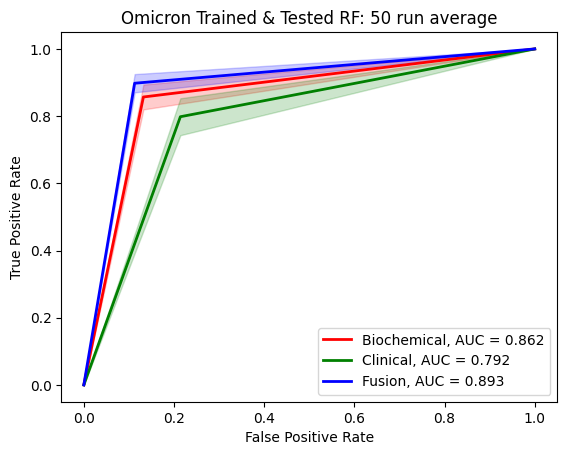

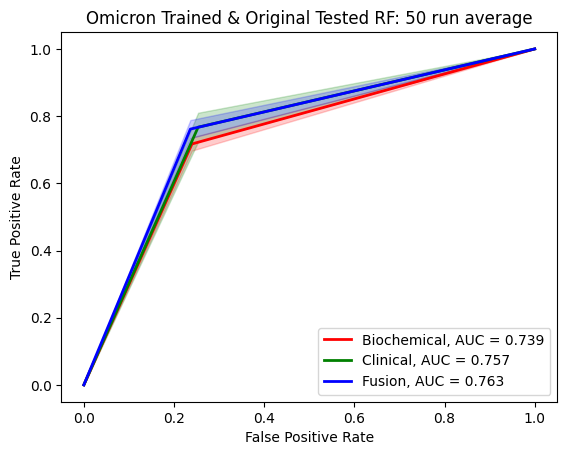

In [ ]:
# ROC Plots---------------------------------------------------------------------
# Plotting the average runs - Omicron Tested
fig, ax = plt.subplots()
ax.plot(bcO_avg_fpr, bcO_avg_tpr, label = 'Biochemical, AUC = %.3f'%bcO_avg_auc, color='red', linewidth=2)
ax.plot(syO_avg_fpr, syO_avg_tpr, label = 'Clinical, AUC = %.3f'%syO_avg_auc, color='green', linewidth=2)
ax.plot(fnO_avg_fpr, fnO_avg_tpr, label = 'Fusion, AUC = %.3f'%fnO_avg_auc, color='blue', linewidth=2)

# Intervals of 1 Standard Deviation
ax.fill_between(bcO_avg_fpr, bcO_avg_tpr + bcO_std_tpr, bcO_avg_tpr - bcO_std_tpr, alpha=0.2, color='red')
ax.fill_between(syO_avg_fpr, syO_avg_tpr + syO_std_tpr, syO_avg_tpr - syO_std_tpr, alpha=0.2, color='green')
ax.fill_between(fnO_avg_fpr, fnO_avg_tpr + fnO_std_tpr, fnO_avg_tpr - fnO_std_tpr, alpha=0.2, color='blue')

plt.title(label='Omicron Trained & Tested RF: '+str(n_runs)+' run average')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Plotting the average runs - Original Tested
fig, ax = plt.subplots()
ax.plot(bcO_avg_fpr1, bcO_avg_tpr1, label = 'Biochemical, AUC = %.3f'%bcO_avg_auc1, color='red', linewidth=2)
ax.plot(syO_avg_fpr1, syO_avg_tpr1, label = 'Clinical, AUC = %.3f'%syO_avg_auc1, color='green', linewidth=2)
ax.plot(fnO_avg_fpr1, fnO_avg_tpr1, label = 'Fusion, AUC = %.3f'%fnO_avg_auc1, color='blue', linewidth=2)

# Intervals of 1 Standard Deviation
ax.fill_between(bcO_avg_fpr1, bcO_avg_tpr1 + bcO_std_tpr1, bcO_avg_tpr1 - bcO_std_tpr1, alpha=0.2, color='red')
ax.fill_between(syO_avg_fpr1, syO_avg_tpr1 + syO_std_tpr1, syO_avg_tpr1 - syO_std_tpr1, alpha=0.2, color='green')
ax.fill_between(fnO_avg_fpr1, fnO_avg_tpr1 + fnO_std_tpr1, fnO_avg_tpr1 - fnO_std_tpr1, alpha=0.2, color='blue')

plt.title(label='Omicron Trained & Original Tested RF: '+str(n_runs)+' run average')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Feature Importance

Text(0.5, 1.0, 'Omicron (Fusion) Trained RF Ranked Features: 50 run average')

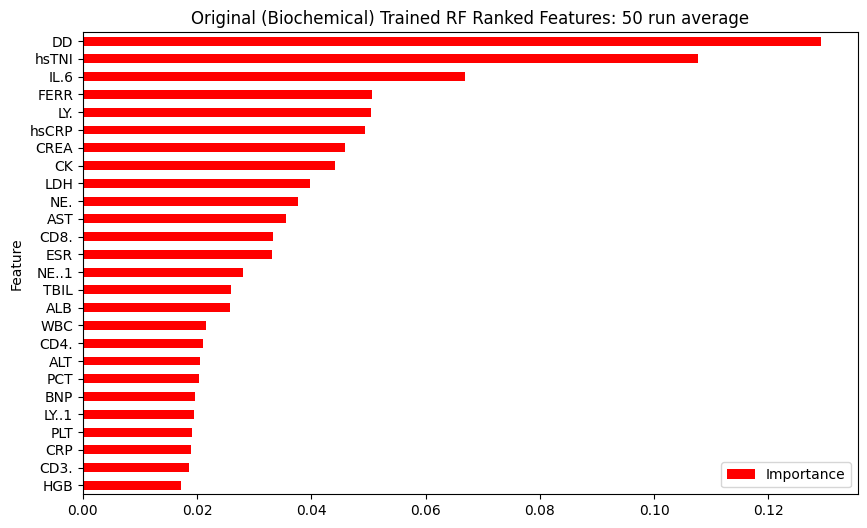

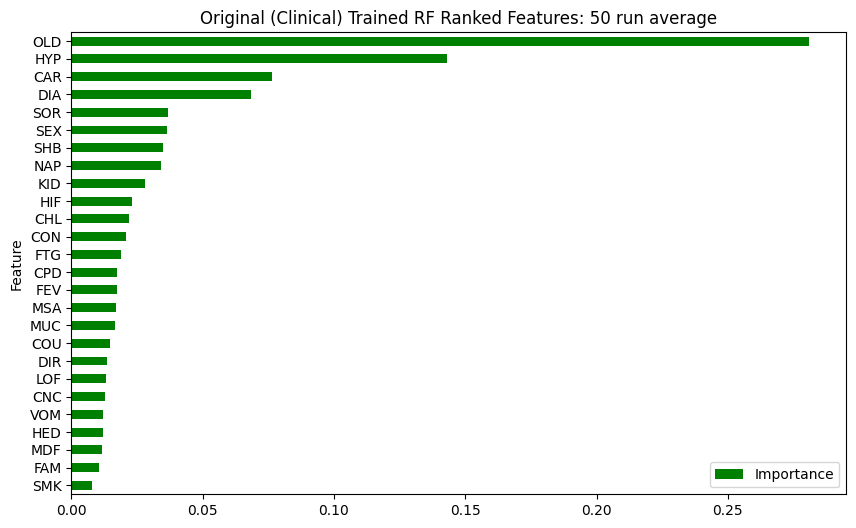

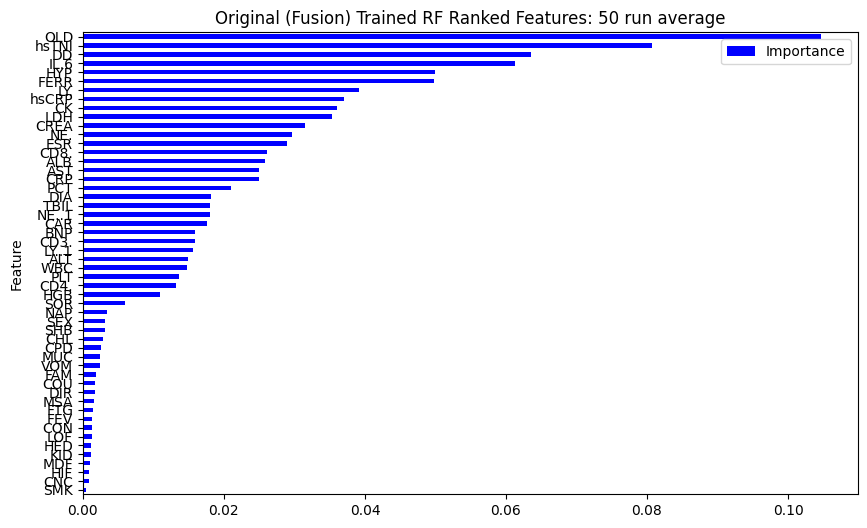

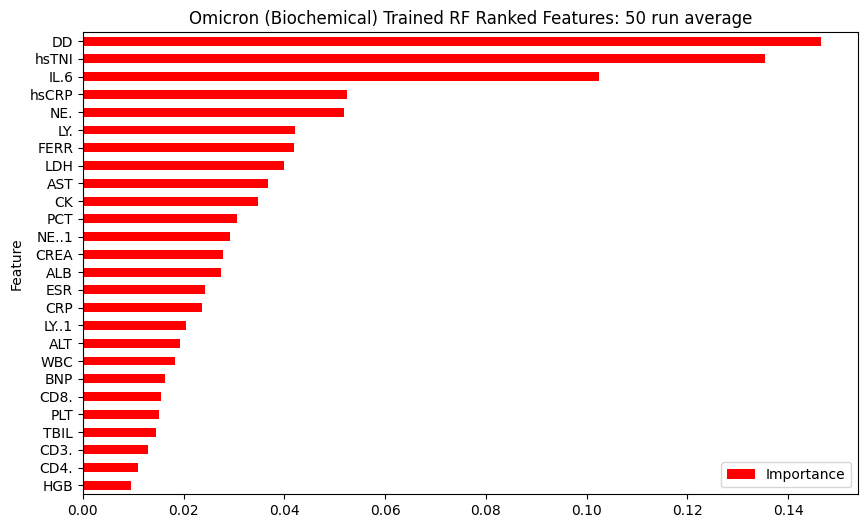

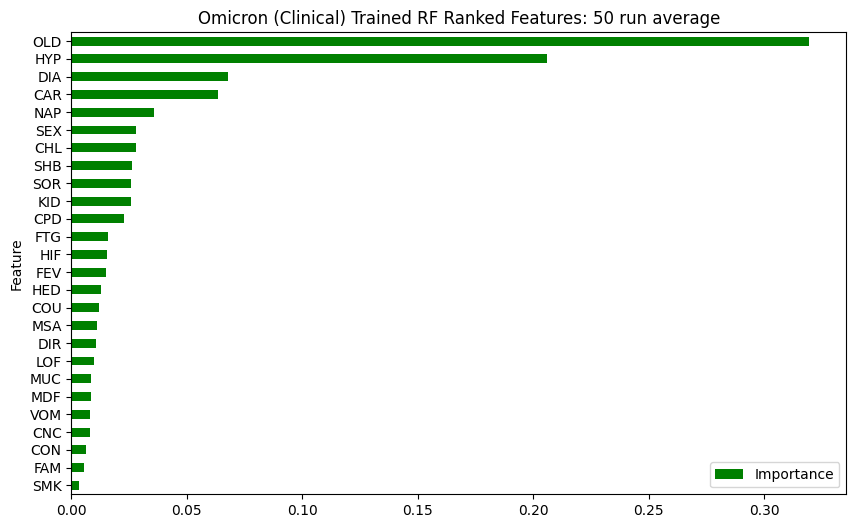

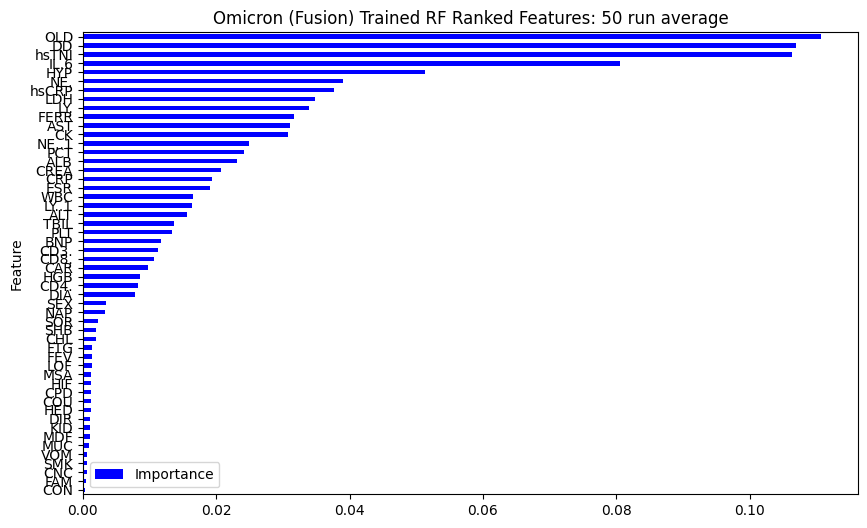

In [ ]:
# Original COVID-19 Data--------------------------------------------------------

# Best Coefficients of Biochemical Models
feature_importance = pd.DataFrame({'Feature': bioChem_trim.columns, 'Importance': bc_mean_coeffs})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', color='red', figsize=(10, 6))
plt.title(label='Original (Biochemical) Trained RF Ranked Features: '+str(n_runs)+' run average')

# Best Coefficients of Clinical Models
feature_importance = pd.DataFrame({'Feature': symp_trim.columns, 'Importance':sy_mean_coeffs})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', color='green', figsize=(10, 6))
plt.title(label='Original (Clinical) Trained RF Ranked Features: '+str(n_runs)+' run average')

# Best Coefficients of Fusion Models
feature_importance = pd.DataFrame({'Feature': multi_trim.columns, 'Importance': fn_mean_coeffs})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', color='blue', figsize=(10, 6))
plt.title(label='Original (Fusion) Trained RF Ranked Features: '+str(n_runs)+' run average')

# Omicron COVID-19 Data--------------------------------------------------------

# Best Coefficients of Biochemical Models
feature_importance = pd.DataFrame({'Feature': bioChemO_trim.columns, 'Importance': bcO_mean_coeffs})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', color='red', figsize=(10, 6))
plt.title(label='Omicron (Biochemical) Trained RF Ranked Features: '+str(n_runs)+' run average')

# Best Coefficients of Clinical Models
feature_importance = pd.DataFrame({'Feature': sympO_trim.columns, 'Importance': syO_mean_coeffs})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', color='green', figsize=(10, 6))
plt.title(label='Omicron (Clinical) Trained RF Ranked Features: '+str(n_runs)+' run average')

# Best Coefficients of Fusion Models
feature_importance = pd.DataFrame({'Feature': multiO_trim.columns, 'Importance': fnO_mean_coeffs})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', color='blue', figsize=(10, 6))
plt.title(label='Omicron (Fusion) Trained RF Ranked Features: '+str(n_runs)+' run average')

## k-Nearest Neighbors



### Original Trained Model

---



#### Hyperparameter Tuning, Training, and Prediction

In [ ]:
# k Nearest Neighbors - Original------------------------------------------------

print('Original Data Runs\n')

# Parameter Grid
parameters = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10], 'weights':('uniform', 'distance'), 'metric':('l1', 'l2', 'cosine')}

# FPR recordings: 1-TNR, for plotting AUC
bc_fpr_runs = [] # Original Trained and Tested
sy_fpr_runs = []
fn_fpr_runs = []

bc_fpr_runs1 = [] # Original Trained and Omicron Tested
sy_fpr_runs1 = []
fn_fpr_runs1 = []

# TPR recordings: Sensitivity, Recall
bc_tpr_runs = [] # Original Trained and Tested
sy_tpr_runs = []
fn_tpr_runs = []

bc_tpr_runs1 = [] # Original Trained and Omicron Tested
sy_tpr_runs1 = []
fn_tpr_runs1 = []

# TNR recordings: Specificity, Sensitivity
bc_tnr_runs = [] # Original Trained and Tested
sy_tnr_runs = []
fn_tnr_runs = []

bc_tnr_runs1 = [] # Original Trained and Omicron Tested
sy_tnr_runs1 = []
fn_tnr_runs1 = []

# AUC recordings
bc_auc_runs = [] # Original Trained and Tested
sy_auc_runs = []
fn_auc_runs = []

bc_auc_runs1 = [] # Original Trained and Omicron Tested
sy_auc_runs1 = []
fn_auc_runs1 = []

# Best parameter recordings
bc_params = []
sy_params = []
fn_params = []

for i in range(n_runs):
  j = i+1
  print('Run: ',j,'------------------------------------\n')

  # Train Test Split------------------------------------------------------------
  bioChem_train, bioChem_test, bioChem_labels_train, bioChem_labels_test = train_test_split(bioChem_trim, bioChem_labels, test_size = 1 / 5)
  symp_train, symp_test, symp_labels_train, symp_labels_test = train_test_split(symp_trim, symp_labels, test_size = 1 / 5)
  multi_train, multi_test, multi_labels_train, multi_labels_test = train_test_split(multi_trim, multi_labels, test_size = 1 / 5)

  # Scaling---------------------------------------------------------------------
  # Biochemical Data
  bioChem_scaler = StandardScaler()
  bioChem_train = bioChem_scaler.fit_transform(bioChem_train)
  bioChem_test = bioChem_scaler.transform(bioChem_test)

  # Clinical Data
  symp_scaler = StandardScaler()
  symp_train = symp_scaler.fit_transform(symp_train)
  symp_test = symp_scaler.transform(symp_test)

  # Fusion Data
  multi_scaler = StandardScaler()
  multi_train = multi_scaler.fit_transform(multi_train)
  multi_test = multi_scaler.transform(multi_test)

  # Model Training Grid Search--------------------------------------------------
  # Biochemical model
  bioChem_kNN = KNeighborsClassifier()
  bioChem_clf = GridSearchCV(bioChem_kNN, parameters)
  bioChem_clf.fit(bioChem_train, bioChem_labels_train)

  # Clinical model
  symp_kNN = KNeighborsClassifier()
  symp_clf = GridSearchCV(symp_kNN, parameters)
  symp_clf.fit(symp_train, symp_labels_train)

  # Fusion model
  multi_kNN = KNeighborsClassifier()
  multi_clf = GridSearchCV(multi_kNN, parameters)
  multi_clf.fit(multi_train, multi_labels_train)

  # View results----------------------------------------------------------------
  target_names = ['Non-Severe COVID', 'Severe COVID']

  # Biochemical results---------------------------------------------------------
  print('Biochemical Results\n')

  # Best estimator
  bc_params.append(bioChem_clf.best_params_)

  # Predicting on testing hold-out data
  bioChem_labels_predict = bioChem_clf.predict(bioChem_test)

  # Predicting on Omicron Data
  bioChemO_trim_scale = bioChem_scaler.transform(bioChemO_trim)
  bioChemO_labels_predict = bioChem_clf.predict(bioChemO_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(bioChem_labels_test, bioChem_labels_predict)
  bc_fpr_runs.append(fpr)
  bc_tpr_runs.append(tpr)

  # Omicron testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(bioChemO_labels, bioChemO_labels_predict)
  bc_fpr_runs1.append(fpr1)
  bc_tpr_runs1.append(tpr1)

  # AUC
  BC_roc_auc = metrics.auc(fpr, tpr)
  bc_auc_runs.append(BC_roc_auc)

  # AUC - Omicron
  BC_roc_auc1 = metrics.auc(fpr1, tpr1)
  bc_auc_runs1.append(BC_roc_auc1)

  # Clinical results------------------------------------------------------------
  print('Clinical Results\n')

  # Best estimator
  sy_params.append(symp_clf.best_params_)

  # Predicting on testing hold-out data
  symp_labels_predict = symp_clf.predict(symp_test)

  # Predicting on Omicron Data
  sympO_trim_scale = symp_scaler.transform(sympO_trim)
  sympO_labels_predict = symp_clf.predict(sympO_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(symp_labels_test, symp_labels_predict)
  sy_fpr_runs.append(fpr)
  sy_tpr_runs.append(tpr)

  # Omicron testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(sympO_labels,sympO_labels_predict)
  sy_fpr_runs1.append(fpr1)
  sy_tpr_runs1.append(tpr1)

  # AUC
  SY_roc_auc = metrics.auc(fpr, tpr)
  sy_auc_runs.append(SY_roc_auc)

  # AUC - Omicron
  SY_roc_auc1 = metrics.auc(fpr1, tpr1)
  sy_auc_runs1.append(SY_roc_auc1)

  # Fusion results--------------------------------------------------------------
  print('Fusion Results\n')

  # Best estimator
  fn_params.append(multi_clf.best_params_)

  # Predicting on testing hold-out data
  multi_labels_predict = multi_clf.predict(multi_test)

  # Predicting on Omicron Data
  multiO_trim_scale = multi_scaler.transform(multiO_trim)
  multiO_labels_predict = multi_clf.predict(multiO_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(multi_labels_test, multi_labels_predict)
  fn_fpr_runs.append(fpr)
  fn_tpr_runs.append(tpr)

  # Omicron testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(multiO_labels, multiO_labels_predict)
  fn_fpr_runs1.append(fpr1)
  fn_tpr_runs1.append(tpr1)

  # AUC
  FN_roc_auc = metrics.auc(fpr, tpr)
  fn_auc_runs.append(FN_roc_auc)

  # AUC - Omicron
  FN_roc_auc1 = metrics.auc(fpr1, tpr1)
  fn_auc_runs1.append(FN_roc_auc1)

print(bc_params)
print(sy_params)
print(fn_params)

Original Data Runs

Run:  1 ------------------------------------



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Biochemical Results

Clinical Results

Fusion Results

Run:  2 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  3 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  4 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  5 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  6 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  7 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  8 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  9 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  10 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  11 --------------------------

#### Calculating Mean and Standard deviation of metrics

In [ ]:
bc_avg_fpr, bc_avg_fpr1, bc_avg_tpr, bc_avg_tpr1, bc_avg_auc, bc_avg_auc1, bc_std_fpr, bc_std_fpr1, bc_std_tpr, bc_std_tpr1, bc_std_auc, bc_std_auc1 = get_Stats(bc_fpr_runs,bc_fpr_runs1,bc_tpr_runs,bc_tpr_runs1,bc_auc_runs,bc_auc_runs1)
sy_avg_fpr, sy_avg_fpr1, sy_avg_tpr, sy_avg_tpr1, sy_avg_auc, sy_avg_auc1, sy_std_fpr, sy_std_fpr1, sy_std_tpr, sy_std_tpr1, sy_std_auc, sy_std_auc1 = get_Stats(sy_fpr_runs,sy_fpr_runs1,sy_tpr_runs,sy_tpr_runs1,sy_auc_runs,sy_auc_runs1)
fn_avg_fpr, fn_avg_fpr1, fn_avg_tpr, fn_avg_tpr1, fn_avg_auc, fn_avg_auc1, fn_std_fpr, fn_std_fpr1, fn_std_tpr, fn_std_tpr1, fn_std_auc, fn_std_auc1 = get_Stats(fn_fpr_runs,fn_fpr_runs1,fn_tpr_runs,fn_tpr_runs1,fn_auc_runs,fn_auc_runs1)

#### Printing Stats

In [ ]:
# Printing Results--------------------------------------------------------------
# FPR
print('Mean FPR, original/original, BC: ', bc_avg_fpr)
print('Mean FPR, original/original, SY: ', sy_avg_fpr)
print('Mean FPR, original/original, FN: ', fn_avg_fpr)

# FPR - Omicron
print('Mean FPR, original/omicron, BC: ', bc_avg_fpr1)
print('Mean FPR, original/omicron, SY: ', sy_avg_fpr1)
print('Mean FPR, original/omicron, FN: ', fn_avg_fpr1)

print('\n')

# TPR
print('Mean TPR, original/original, BC: ', bc_avg_tpr)
print('Mean TPR, original/original, SY: ', sy_avg_tpr)
print('Mean TPR, original/original, FN: ', fn_avg_tpr)

# TPR - Omicron
print('Mean TPR, original/omicron, BC: ', bc_avg_tpr1)
print('Mean TPR, original/omicron, SY: ', sy_avg_tpr1)
print('Mean TPR, original/omicron, FN: ', fn_avg_tpr1)
"""
print('\n')

# TNR
print('Mean TNR, original/original, BC: ', bc_avg_tnr)
print('Mean TNR, original/original, SY: ', sy_avg_tnr)
print('Mean TNR, original/original, FN: ', fn_avg_tnr)

# TNR - Omicron
print('Mean TNR, original/omicron, BC: ', bc_avg_tnr1)
print('Mean TNR, original/omicron, SY: ', sy_avg_tnr1)
print('Mean TNR, original/omicron, FN: ', fn_avg_tnr1)

print('\n')"""
print('\n')

# AUC
print('AUC of biochem composite ROC curve',metrics.auc(bc_avg_fpr, bc_avg_tpr))
print('AUC of symp composite ROC curve',metrics.auc(sy_avg_fpr, sy_avg_tpr))
print('AUC of fusion composite ROC curve',metrics.auc(fn_avg_fpr, fn_avg_tpr))
print('\n')

# AUC - Omicron
print('AUC of biochem composite ROC curve (Omicron)',metrics.auc(bc_avg_fpr1, bc_avg_tpr1))
print('AUC of symp composite ROC curve (Omicron)',metrics.auc(sy_avg_fpr1, sy_avg_tpr1))
print('AUC of fusion composite ROC curve (Omicron)',metrics.auc(fn_avg_fpr1, fn_avg_tpr1))
print('\n')

# AUC
print('AUC STDEV of biochem composite ROC curve',bc_std_auc)
print('AUC STDEV of symp composite ROC curve',sy_std_auc)
print('AUC STDEV of fusion composite ROC curve',fn_std_auc)
print('\n')

# AUC - Omicron
print('AUC STDEV of biochem composite ROC curve (Omicron)',bc_std_auc1)
print('AUC STDEV of symp composite ROC curve (Omicron)',sy_std_auc1)
print('AUC STDEV of fusion composite ROC curve (Omicron)',fn_std_auc1)

Mean FPR, original/original, BC:  [0.         0.16526268 1.        ]
Mean FPR, original/original, SY:  [0.         0.20259437 1.        ]
Mean FPR, original/original, FN:  [0.         0.18602175 1.        ]
Mean FPR, original/omicron, BC:  [0.      0.13092 1.     ]
Mean FPR, original/omicron, SY:  [0.      0.16052 1.     ]
Mean FPR, original/omicron, FN:  [0.      0.11636 1.     ]


Mean TPR, original/original, BC:  [0.         0.38137528 1.        ]
Mean TPR, original/original, SY:  [0.         0.53907148 1.        ]
Mean TPR, original/original, FN:  [0.         0.56986186 1.        ]
Mean TPR, original/omicron, BC:  [0.     0.5108 1.    ]
Mean TPR, original/omicron, SY:  [0.      0.60848 1.     ]
Mean TPR, original/omicron, FN:  [0.      0.69928 1.     ]


AUC of biochem composite ROC curve 0.6080563021882137
AUC of symp composite ROC curve 0.6682385538338483
AUC of fusion composite ROC curve 0.6919200557418604


AUC of biochem composite ROC curve (Omicron) 0.6899399999999999
AUC of 

#### Displaying ROC Plots and AUC

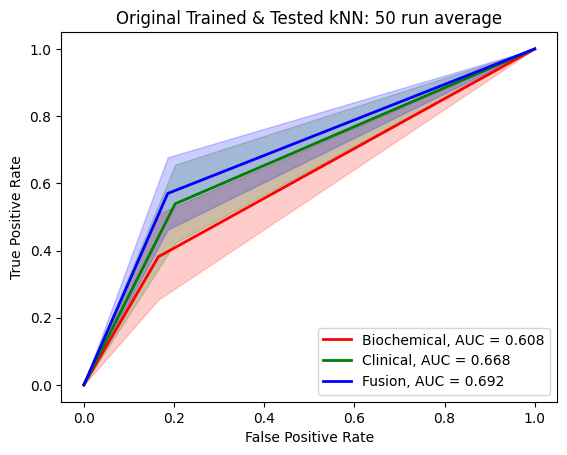

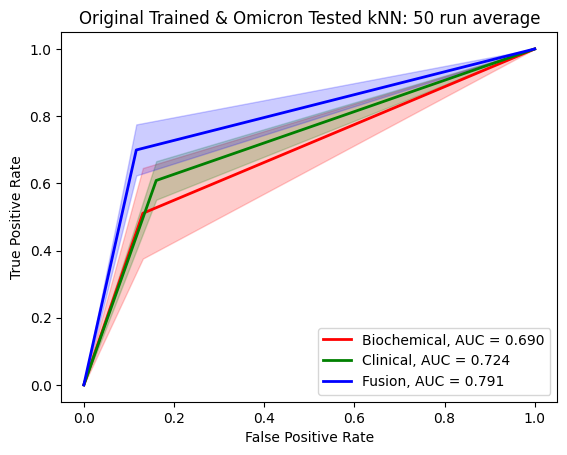

In [ ]:
# ROC Plots---------------------------------------------------------------------
# Plotting the average runs - Original Tested
fig, ax = plt.subplots()
ax.plot(bc_avg_fpr, bc_avg_tpr, label = 'Biochemical, AUC = %.3f'%bc_avg_auc, color='red', linewidth=2)
ax.plot(sy_avg_fpr, sy_avg_tpr, label = 'Clinical, AUC = %.3f'%sy_avg_auc, color='green', linewidth=2)
ax.plot(fn_avg_fpr, fn_avg_tpr, label = 'Fusion, AUC = %.3f'%fn_avg_auc, color='blue', linewidth=2)

# Intervals of 1 Standard Deviation
ax.fill_between(bc_avg_fpr, bc_avg_tpr + bc_std_tpr, bc_avg_tpr - bc_std_tpr, alpha=0.2, color='red')
ax.fill_between(sy_avg_fpr, sy_avg_tpr + sy_std_tpr, sy_avg_tpr - sy_std_tpr, alpha=0.2, color='green')
ax.fill_between(fn_avg_fpr, fn_avg_tpr + fn_std_tpr, fn_avg_tpr - fn_std_tpr, alpha=0.2, color='blue')

plt.title(label='Original Trained & Tested kNN: '+str(n_runs)+' run average')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Plotting the average runs - Omicron Tested
fig, ax = plt.subplots()
ax.plot(bc_avg_fpr1, bc_avg_tpr1, label = 'Biochemical, AUC = %.3f'%bc_avg_auc1, color='red', linewidth=2)
ax.plot(sy_avg_fpr1, sy_avg_tpr1, label = 'Clinical, AUC = %.3f'%sy_avg_auc1, color='green', linewidth=2)
ax.plot(fn_avg_fpr1, fn_avg_tpr1, label = 'Fusion, AUC = %.3f'%fn_avg_auc1, color='blue', linewidth=2)

# Intervals of 1 Standard Deviation
ax.fill_between(bc_avg_fpr1, bc_avg_tpr1 + bc_std_tpr1, bc_avg_tpr1 - bc_std_tpr1, alpha=0.2, color='red')
ax.fill_between(sy_avg_fpr1, sy_avg_tpr1 + sy_std_tpr1, sy_avg_tpr1 - sy_std_tpr1, alpha=0.2, color='green')
ax.fill_between(fn_avg_fpr1, fn_avg_tpr1 + fn_std_tpr1, fn_avg_tpr1 - fn_std_tpr1, alpha=0.2, color='blue')

plt.title(label='Original Trained & Omicron Tested kNN: '+str(n_runs)+' run average')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Omicron Trained Model

---



#### Hyperparameter Tuning, Training, and Prediction



In [ ]:
# k Nearest Neighbors - Omicron-------------------------------------------------

print('Omicron Data Runs\n')

# Parameter Grid
parameters = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10], 'weights':('uniform', 'distance'), 'metric':('l1', 'l2', 'cosine')}

# FPR recordings: 1 - TNR, for plotting ROC
bcO_fpr_runs = [] # Omicron trained and tested
syO_fpr_runs = []
fnO_fpr_runs = []

bcO_fpr_runs1 = [] # Omicron trained and original tested
syO_fpr_runs1 = []
fnO_fpr_runs1 = []

# TPR recordings: Sensitivity, Recall
bcO_tpr_runs = [] # Omicron trained and tested
syO_tpr_runs = []
fnO_tpr_runs = []

bcO_tpr_runs1 = [] # Omicron trained and original tested
syO_tpr_runs1 = []
fnO_tpr_runs1 = []

# TNR recordings: Specificity, Sensitivity
bcO_tnr_runs = [] # Omicron Trained and Tested
syO_tnr_runs = []
fnO_tnr_runs = []

bcO_tnr_runs1 = [] # Omicron Trained and original Tested
syO_tnr_runs1 = []
fnO_tnr_runs1 = []

# AUC recordings
bcO_auc_runs = [] # Omicron trained and tested
syO_auc_runs = []
fnO_auc_runs = []

bcO_auc_runs1 = [] # Omicron trained and original tested
syO_auc_runs1 = []
fnO_auc_runs1 = []

# Best parameter recordings
bcO_params = []
syO_params = []
fnO_params = []

for i in range(n_runs):
  j = i+1
  print('Run: ',j,'------------------------------------\n')

  # Train Test Split------------------------------------------------------------
  bioChemO_train, bioChemO_test, bioChemO_labels_train, bioChemO_labels_test = train_test_split(bioChemO_trim, bioChemO_labels, test_size = 1 / 5)
  sympO_train, sympO_test, sympO_labels_train, sympO_labels_test = train_test_split(sympO_trim, sympO_labels, test_size = 1 / 5)
  multiO_train, multiO_test, multiO_labels_train, multiO_labels_test = train_test_split(multiO_trim, multiO_labels, test_size = 1 / 5)

  # Scaling---------------------------------------------------------------------
  # Biochemical Data
  bioChemO_scaler = StandardScaler()
  bioChemO_train = bioChemO_scaler.fit_transform(bioChemO_train)
  bioChemO_test = bioChemO_scaler.transform(bioChemO_test)

  # Clinical Data
  sympO_scaler = StandardScaler()
  sympO_train = sympO_scaler.fit_transform(sympO_train)
  sympO_test = sympO_scaler.transform(sympO_test)

  # Fusion Data
  multiO_scaler = StandardScaler()
  multiO_train = multiO_scaler.fit_transform(multiO_train)
  multiO_test = multiO_scaler.transform(multiO_test)

  # Model Training Grid Search--------------------------------------------------
  bioChemO_kNN = KNeighborsClassifier()
  bioChemO_clf = GridSearchCV(bioChemO_kNN, parameters)
  bioChemO_clf.fit(bioChemO_train, bioChemO_labels_train)

  # Clinical model
  sympO_kNN = KNeighborsClassifier()
  sympO_clf = GridSearchCV(sympO_kNN, parameters)
  sympO_clf.fit(sympO_train, sympO_labels_train)

  # Fusion model
  multiO_kNN = KNeighborsClassifier()
  multiO_clf = GridSearchCV(multiO_kNN, parameters)
  multiO_clf.fit(multiO_train, multiO_labels_train)

  # View results----------------------------------------------------------------
  target_names = ['Non-Severe COVID', 'Severe COVID']

  # Biochemical results---------------------------------------------------------
  print('Biochemical Results\n')

  # Best estimator
  bcO_params.append(bioChemO_clf.best_params_)

  # Predicting on testing hold-out data
  bioChemO_labels_predict = bioChemO_clf.predict(bioChemO_test)

  # Predicting on original COIVD-19 data
  bioChem_trim_scale = bioChemO_scaler.transform(bioChem_trim)
  bioChem_labels_predict1 = bioChemO_clf.predict(bioChem_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(bioChemO_labels_test, bioChemO_labels_predict)
  bcO_fpr_runs.append(fpr)
  bcO_tpr_runs.append(tpr)

  # Original testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(bioChem_labels, bioChem_labels_predict1)
  bcO_fpr_runs1.append(fpr1)
  bcO_tpr_runs1.append(tpr1)

  # AUC
  BCO_roc_auc = metrics.auc(fpr, tpr)
  bcO_auc_runs.append(BCO_roc_auc)

  # AUC - Original
  BCO_roc_auc1 = metrics.auc(fpr1, tpr1)
  bcO_auc_runs1.append(BCO_roc_auc1)

  # Clinical results---------------------------------------------------------
  print('Clinical Results\n')

  # Best estimator
  syO_params.append(sympO_clf.best_params_)

  # Predicting on testing hold-out data
  sympO_labels_predict = sympO_clf.predict(sympO_test)

  # Predicting on original COIVD-19 data
  symp_trim_scale = sympO_scaler.transform(symp_trim)
  symp_labels_predict1 = sympO_clf.predict(symp_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(sympO_labels_test, sympO_labels_predict)
  syO_fpr_runs.append(fpr)
  syO_tpr_runs.append(tpr)

  # Original testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(symp_labels, symp_labels_predict1)
  syO_fpr_runs1.append(fpr1)
  syO_tpr_runs1.append(tpr1)

  # AUC
  SYO_roc_auc = metrics.auc(fpr, tpr)
  syO_auc_runs.append(SYO_roc_auc)

  # AUC - Original
  SYO_roc_auc1 = metrics.auc(fpr1, tpr1)
  syO_auc_runs1.append(SYO_roc_auc1)

  # Fusion results--------------------------------------------------------------
  print('Fusion Results\n')

  # Best estimator
  fnO_params.append(multiO_clf.best_params_)

  # Predicting on testing hold-out data
  multiO_labels_predict = multiO_clf.predict(multiO_test)

  # Predicting on original COIVD-19 data
  multi_trim_scale = multiO_scaler.transform(multi_trim)
  multi_labels_predict1 = multiO_clf.predict(multi_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(multiO_labels_test, multiO_labels_predict)
  fnO_fpr_runs.append(fpr)
  fnO_tpr_runs.append(tpr)

  # Original testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(multi_labels, multi_labels_predict1)
  fnO_fpr_runs1.append(fpr1)
  fnO_tpr_runs1.append(tpr1)

  # AUC
  FNO_roc_auc = metrics.auc(fpr, tpr)
  fnO_auc_runs.append(FNO_roc_auc)

  # AUC - Original
  FNO_roc_auc1 = metrics.auc(fpr1, tpr1)
  fnO_auc_runs1.append(FNO_roc_auc1)

print(bcO_params)
print(syO_params)
print(fnO_params)

Omicron Data Runs

Run:  1 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  2 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  3 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  4 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  5 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  6 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  7 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  8 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  9 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  10 ------------------------------------

Biochemical Results

Clin

#### Calculating Mean and Standard deviation of metrics

In [ ]:
bcO_avg_fpr, bcO_avg_fpr1, bcO_avg_tpr, bcO_avg_tpr1, bcO_avg_auc, bcO_avg_auc1, bcO_std_fpr, bcO_std_fpr1, bcO_std_tpr, bcO_std_tpr1, bcO_std_auc, bcO_std_auc1 = get_Stats(bcO_fpr_runs,bcO_fpr_runs1,bcO_tpr_runs,bcO_tpr_runs1,bcO_auc_runs,bcO_auc_runs1)
syO_avg_fpr, syO_avg_fpr1, syO_avg_tpr, syO_avg_tpr1, syO_avg_auc, syO_avg_auc1, syO_std_fpr, syO_std_fpr1, syO_std_tpr, syO_std_tpr1, syO_std_auc, syO_std_auc1 = get_Stats(syO_fpr_runs,syO_fpr_runs1,syO_tpr_runs,syO_tpr_runs1,syO_auc_runs,syO_auc_runs1)
fnO_avg_fpr, fnO_avg_fpr1, fnO_avg_tpr, fnO_avg_tpr1, fnO_avg_auc, fnO_avg_auc1, fnO_std_fpr, fnO_std_fpr1, fnO_std_tpr, fnO_std_tpr1, fnO_std_auc, fnO_std_auc1 = get_Stats(fnO_fpr_runs,fnO_fpr_runs1,fnO_tpr_runs,fnO_tpr_runs1,fnO_auc_runs,fnO_auc_runs1)

#### Printing Stats

In [ ]:
# Printing Results--------------------------------------------------------------
# FPR
print('Mean FPR, original/original, BC: ', bcO_avg_fpr)
print('Mean FPR, original/original, SY: ', syO_avg_fpr)
print('Mean FPR, original/original, FN: ', fnO_avg_fpr)

# FPR - Omicron
print('Mean FPR, original/omicron, BC: ', bcO_avg_fpr1)
print('Mean FPR, original/omicron, SY: ', syO_avg_fpr1)
print('Mean FPR, original/omicron, FN: ', fnO_avg_fpr1)

print('\n')

# TPR
print('Mean TPR, original/original, BC: ', bcO_avg_tpr)
print('Mean TPR, original/original, SY: ', syO_avg_tpr)
print('Mean TPR, original/original, FN: ', fnO_avg_tpr)

# TPR - Omicron
print('Mean TPR, original/omicron, BC: ', bcO_avg_tpr1)
print('Mean TPR, original/omicron, SY: ', syO_avg_tpr1)
print('Mean TPR, original/omicron, FN: ', fnO_avg_tpr1)
"""
print('\n')

# TNR
print('Mean TNR, original/original, BC: ', bc_avg_tnr)
print('Mean TNR, original/original, SY: ', sy_avg_tnr)
print('Mean TNR, original/original, FN: ', fn_avg_tnr)

# TNR - Omicron
print('Mean TNR, original/omicron, BC: ', bc_avg_tnr1)
print('Mean TNR, original/omicron, SY: ', sy_avg_tnr1)
print('Mean TNR, original/omicron, FN: ', fn_avg_tnr1)

print('\n')"""
print('\n')

# AUC
print('AUC of biochem composite ROC curve',metrics.auc(bcO_avg_fpr, bc_avg_tpr))
print('AUC of symp composite ROC curve',metrics.auc(syO_avg_fpr, sy_avg_tpr))
print('AUC of fusion composite ROC curve',metrics.auc(fnO_avg_fpr, fn_avg_tpr))
print('\n')

# AUC - Original
print('AUC of biochem composite ROC curve (Original)',metrics.auc(bcO_avg_fpr1, bc_avg_tpr1))
print('AUC of symp composite ROC curve (Original)',metrics.auc(syO_avg_fpr1, sy_avg_tpr1))
print('AUC of fusion composite ROC curve (Original)',metrics.auc(fnO_avg_fpr1, fn_avg_tpr1))
print('\n')

# AUC
print('AUC STDEV of biochem composite ROC curve',bcO_std_auc)
print('AUC STDEV of symp composite ROC curve',syO_std_auc)
print('AUC STDEV of fusion composite ROC curve',fnO_std_auc)
print('\n')

# AUC - Original
print('AUC STDEV of biochem composite ROC curve (Original)',bcO_std_auc1)
print('AUC STDEV of symp composite ROC curve (Original)',syO_std_auc1)
print('AUC STDEV of fusion composite ROC curve (Original)',fnO_std_auc1)

Mean FPR, original/original, BC:  [0.         0.14974864 1.        ]
Mean FPR, original/original, SY:  [0.         0.20385735 1.        ]
Mean FPR, original/original, FN:  [0.         0.11100745 1.        ]
Mean FPR, original/omicron, BC:  [0.         0.20214953 1.        ]
Mean FPR, original/omicron, SY:  [0.        0.2328972 1.       ]
Mean FPR, original/omicron, FN:  [0.         0.17214953 1.        ]


Mean TPR, original/original, BC:  [0.         0.74885542 1.        ]
Mean TPR, original/original, SY:  [0.         0.78096545 1.        ]
Mean TPR, original/original, FN:  [0.         0.82611446 1.        ]
Mean TPR, original/omicron, BC:  [0.         0.52972973 1.        ]
Mean TPR, original/omicron, SY:  [0.         0.70283784 1.        ]
Mean TPR, original/omicron, FN:  [0.         0.63824324 1.        ]


AUC of biochem composite ROC curve 0.6158133235964943
AUC of symp composite ROC curve 0.6676070633790675
AUC of fusion composite ROC curve 0.7294272077809081


AUC of biochem co

#### Displaying ROC Plots and AUC

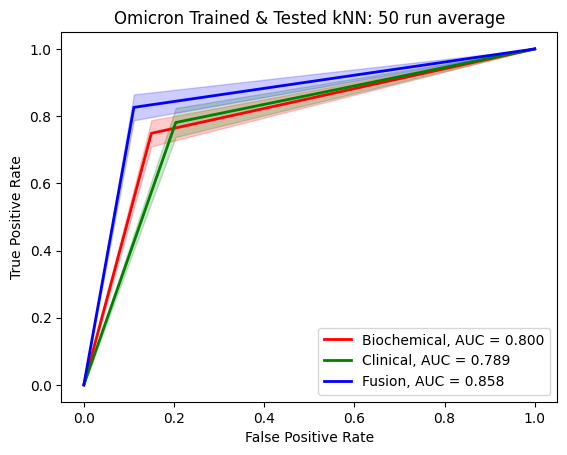

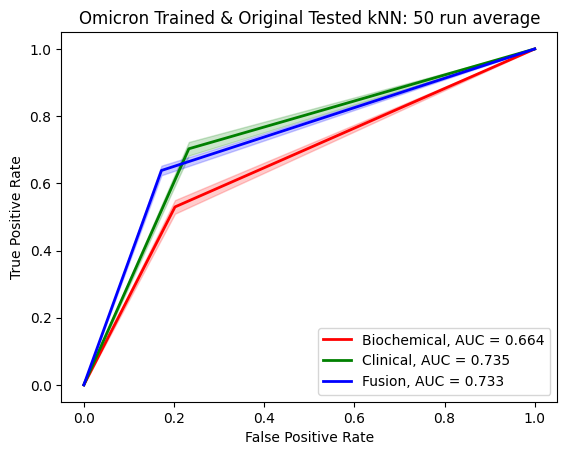

In [ ]:
# ROC Plots---------------------------------------------------------------------
# Plotting the average runs - Omicron Tested
fig, ax = plt.subplots()
ax.plot(bcO_avg_fpr, bcO_avg_tpr, label = 'Biochemical, AUC = %.3f'%bcO_avg_auc, color='red', linewidth=2)
ax.plot(syO_avg_fpr, syO_avg_tpr, label = 'Clinical, AUC = %.3f'%syO_avg_auc, color='green', linewidth=2)
ax.plot(fnO_avg_fpr, fnO_avg_tpr, label = 'Fusion, AUC = %.3f'%fnO_avg_auc, color='blue', linewidth=2)

# Intervals of 1 Standard Deviation
ax.fill_between(bcO_avg_fpr, bcO_avg_tpr + bcO_std_tpr, bcO_avg_tpr - bcO_std_tpr, alpha=0.2, color='red')
ax.fill_between(syO_avg_fpr, syO_avg_tpr + syO_std_tpr, syO_avg_tpr - syO_std_tpr, alpha=0.2, color='green')
ax.fill_between(fnO_avg_fpr, fnO_avg_tpr + fnO_std_tpr, fnO_avg_tpr - fnO_std_tpr, alpha=0.2, color='blue')

plt.title(label='Omicron Trained & Tested kNN: '+str(n_runs)+' run average')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Plotting the average runs - Original Tested
fig, ax = plt.subplots()
ax.plot(bcO_avg_fpr1, bcO_avg_tpr1, label = 'Biochemical, AUC = %.3f'%bcO_avg_auc1, color='red', linewidth=2)
ax.plot(syO_avg_fpr1, syO_avg_tpr1, label = 'Clinical, AUC = %.3f'%syO_avg_auc1, color='green', linewidth=2)
ax.plot(fnO_avg_fpr1, fnO_avg_tpr1, label = 'Fusion, AUC = %.3f'%fnO_avg_auc1, color='blue', linewidth=2)

# Intervals of 1 Standard Deviation
ax.fill_between(bcO_avg_fpr1, bcO_avg_tpr1 + bcO_std_tpr1, bcO_avg_tpr1 - bcO_std_tpr1, alpha=0.2, color='red')
ax.fill_between(syO_avg_fpr1, syO_avg_tpr1 + syO_std_tpr1, syO_avg_tpr1 - syO_std_tpr1, alpha=0.2, color='green')
ax.fill_between(fnO_avg_fpr1, fnO_avg_tpr1 + fnO_std_tpr1, fnO_avg_tpr1 - fnO_std_tpr1, alpha=0.2, color='blue')

plt.title(label='Omicron Trained & Original Tested kNN: '+str(n_runs)+' run average')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## Support Vector Machines

### Original Trained Model

---



#### Hyperparameter Tuning, Training, and Prediction



In [ ]:
# Support Vector Machines - Original--------------------------------------------

print('Original Data Runs\n')

# Parameter Grid
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid')}

# FPR recordings: 1-TNR, for plotting AUC
bc_fpr_runs = [] # Original Trained and Tested
sy_fpr_runs = []
fn_fpr_runs = []

bc_fpr_runs1 = [] # Original Trained and Omicron Tested
sy_fpr_runs1 = []
fn_fpr_runs1 = []

# TPR recordings: Sensitivity, Recall
bc_tpr_runs = [] # Original Trained and Tested
sy_tpr_runs = []
fn_tpr_runs = []

bc_tpr_runs1 = [] # Original Trained and Omicron Tested
sy_tpr_runs1 = []
fn_tpr_runs1 = []

# TNR recordings: Specificity, Sensitivity
bc_tnr_runs = [] # Original Trained and Tested
sy_tnr_runs = []
fn_tnr_runs = []

bc_tnr_runs1 = [] # Original Trained and Omicron Tested
sy_tnr_runs1 = []
fn_tnr_runs1 = []

# AUC recordings
bc_auc_runs = [] # Original Trained and Tested
sy_auc_runs = []
fn_auc_runs = []

bc_auc_runs1 = [] # Original Trained and Omicron Tested
sy_auc_runs1 = []
fn_auc_runs1 = []

# Best parameter recordings
bc_params = []
sy_params = []
fn_params = []

for i in range(n_runs):
  j = i+1
  print('Run: ',j,'------------------------------------\n')

  # Train Test Split------------------------------------------------------------
  bioChem_train, bioChem_test, bioChem_labels_train, bioChem_labels_test = train_test_split(bioChem_trim, bioChem_labels, test_size = 1 / 5)
  symp_train, symp_test, symp_labels_train, symp_labels_test = train_test_split(symp_trim, symp_labels, test_size = 1 / 5)
  multi_train, multi_test, multi_labels_train, multi_labels_test = train_test_split(multi_trim, multi_labels, test_size = 1 / 5)

  # Scaling---------------------------------------------------------------------
  # Biochemical Data
  bioChem_scaler = StandardScaler()
  bioChem_train = bioChem_scaler.fit_transform(bioChem_train)
  bioChem_test = bioChem_scaler.transform(bioChem_test)

  # Clinical Data
  symp_scaler = StandardScaler()
  symp_train = symp_scaler.fit_transform(symp_train)
  symp_test = symp_scaler.transform(symp_test)

  # Fusion Data
  multi_scaler = StandardScaler()
  multi_train = multi_scaler.fit_transform(multi_train)
  multi_test = multi_scaler.transform(multi_test)

  # Model Training Grid Search--------------------------------------------------
  # Biochemical model
  bioChem_SVM = svm.SVC()
  bioChem_clf = GridSearchCV(bioChem_SVM, parameters)
  bioChem_clf.fit(bioChem_train, bioChem_labels_train)

  # Clinical model
  symp_SVM = svm.SVC()
  symp_clf = GridSearchCV(symp_SVM, parameters)
  symp_clf.fit(symp_train, symp_labels_train)

  # Fusion model
  multi_SVM = svm.SVC()
  multi_clf = GridSearchCV(multi_SVM, parameters)
  multi_clf.fit(multi_train, multi_labels_train)

  # View results----------------------------------------------------------------
  target_names = ['Non-Severe COVID', 'Severe COVID']

  # Biochemical results---------------------------------------------------------
  print('Biochemical Results\n')

  # Best estimator
  bc_params.append(bioChem_clf.best_params_)

  # Predicting on testing hold-out data
  bioChem_labels_predict = bioChem_clf.predict(bioChem_test)

  # Predicting on Omicron Data
  bioChemO_trim_scale = bioChem_scaler.transform(bioChemO_trim)
  bioChemO_labels_predict = bioChem_clf.predict(bioChemO_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(bioChem_labels_test, bioChem_labels_predict)
  bc_fpr_runs.append(fpr)
  bc_tpr_runs.append(tpr)

  # Omicron testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(bioChemO_labels, bioChemO_labels_predict)
  bc_fpr_runs1.append(fpr1)
  bc_tpr_runs1.append(tpr1)

  # AUC
  BC_roc_auc = metrics.auc(fpr, tpr)
  bc_auc_runs.append(BC_roc_auc)

  # AUC - Omicron
  BC_roc_auc1 = metrics.auc(fpr1, tpr1)
  bc_auc_runs1.append(BC_roc_auc1)

  # Clinical results------------------------------------------------------------
  print('Clinical Results\n')

  # Best estimator
  sy_params.append(symp_clf.best_params_)

  # Predicting on testing hold-out data
  symp_labels_predict = symp_clf.predict(symp_test)

  # Predicting on Omicron Data
  sympO_trim_scale = symp_scaler.transform(sympO_trim)
  sympO_labels_predict = symp_clf.predict(sympO_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(symp_labels_test, symp_labels_predict)
  sy_fpr_runs.append(fpr)
  sy_tpr_runs.append(tpr)

  # Omicron testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(sympO_labels,sympO_labels_predict)
  sy_fpr_runs1.append(fpr1)
  sy_tpr_runs1.append(tpr1)

  # AUC
  SY_roc_auc = metrics.auc(fpr, tpr)
  sy_auc_runs.append(SY_roc_auc)

  # AUC - Omicron
  SY_roc_auc1 = metrics.auc(fpr1, tpr1)
  sy_auc_runs1.append(SY_roc_auc1)

  # Fusion results--------------------------------------------------------------
  print('Fusion Results\n')

  # Best estimator
  fn_params.append(multi_clf.best_params_)

  # Predicting on testing hold-out data
  multi_labels_predict = multi_clf.predict(multi_test)

  # Predicting on Omicron Data
  multiO_trim_scale = multi_scaler.transform(multiO_trim)
  multiO_labels_predict = multi_clf.predict(multiO_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(multi_labels_test, multi_labels_predict)
  fn_fpr_runs.append(fpr)
  fn_tpr_runs.append(tpr)

  # Omicron testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(multiO_labels, multiO_labels_predict)
  fn_fpr_runs1.append(fpr1)
  fn_tpr_runs1.append(tpr1)

  # AUC
  FN_roc_auc = metrics.auc(fpr, tpr)
  fn_auc_runs.append(FN_roc_auc)

  # AUC - Omicron
  FN_roc_auc1 = metrics.auc(fpr1, tpr1)
  fn_auc_runs1.append(FN_roc_auc1)

print(bc_params)
print(sy_params)
print(fn_params)

Original Data Runs

Run:  1 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  2 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  3 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  4 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  5 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  6 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  7 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  8 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  9 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  10 ------------------------------------

Biochemical Results

Cli

#### Calculating Mean and Standard Deviation of metrics

In [ ]:
bc_avg_fpr, bc_avg_fpr1, bc_avg_tpr, bc_avg_tpr1, bc_avg_auc, bc_avg_auc1, bc_std_fpr, bc_std_fpr1, bc_std_tpr, bc_std_tpr1, bc_std_auc, bc_std_auc1 = get_Stats(bc_fpr_runs,bc_fpr_runs1,bc_tpr_runs,bc_tpr_runs1,bc_auc_runs,bc_auc_runs1)
sy_avg_fpr, sy_avg_fpr1, sy_avg_tpr, sy_avg_tpr1, sy_avg_auc, sy_avg_auc1, sy_std_fpr, sy_std_fpr1, sy_std_tpr, sy_std_tpr1, sy_std_auc, sy_std_auc1 = get_Stats(sy_fpr_runs,sy_fpr_runs1,sy_tpr_runs,sy_tpr_runs1,sy_auc_runs,sy_auc_runs1)
fn_avg_fpr, fn_avg_fpr1, fn_avg_tpr, fn_avg_tpr1, fn_avg_auc, fn_avg_auc1, fn_std_fpr, fn_std_fpr1, fn_std_tpr, fn_std_tpr1, fn_std_auc, fn_std_auc1 = get_Stats(fn_fpr_runs,fn_fpr_runs1,fn_tpr_runs,fn_tpr_runs1,fn_auc_runs,fn_auc_runs1)

#### Printing Stats

In [ ]:
# Printing Results--------------------------------------------------------------
# FPR
print('Mean FPR, original/original, BC: ', bc_avg_fpr)
print('Mean FPR, original/original, SY: ', sy_avg_fpr)
print('Mean FPR, original/original, FN: ', fn_avg_fpr)

# FPR - Omicron
print('Mean FPR, original/omicron, BC: ', bc_avg_fpr1)
print('Mean FPR, original/omicron, SY: ', sy_avg_fpr1)
print('Mean FPR, original/omicron, FN: ', fn_avg_fpr1)

print('\n')

# TPR
print('Mean TPR, original/original, BC: ', bc_avg_tpr)
print('Mean TPR, original/original, SY: ', sy_avg_tpr)
print('Mean TPR, original/original, FN: ', fn_avg_tpr)

# TPR - Omicron
print('Mean TPR, original/omicron, BC: ', bc_avg_tpr1)
print('Mean TPR, original/omicron, SY: ', sy_avg_tpr1)
print('Mean TPR, original/omicron, FN: ', fn_avg_tpr1)
"""
print('\n')

# TNR
print('Mean TNR, original/original, BC: ', bc_avg_tnr)
print('Mean TNR, original/original, SY: ', sy_avg_tnr)
print('Mean TNR, original/original, FN: ', fn_avg_tnr)

# TNR - Omicron
print('Mean TNR, original/omicron, BC: ', bc_avg_tnr1)
print('Mean TNR, original/omicron, SY: ', sy_avg_tnr1)
print('Mean TNR, original/omicron, FN: ', fn_avg_tnr1)

print('\n')"""
print('\n')

# AUC
print('AUC of biochem composite ROC curve',metrics.auc(bc_avg_fpr, bc_avg_tpr))
print('AUC of symp composite ROC curve',metrics.auc(sy_avg_fpr, sy_avg_tpr))
print('AUC of fusion composite ROC curve',metrics.auc(fn_avg_fpr, fn_avg_tpr))
print('\n')

# AUC - Omicron
print('AUC of biochem composite ROC curve (Omicron)',metrics.auc(bc_avg_fpr1, bc_avg_tpr1))
print('AUC of symp composite ROC curve (Omicron)',metrics.auc(sy_avg_fpr1, sy_avg_tpr1))
print('AUC of fusion composite ROC curve (Omicron)',metrics.auc(fn_avg_fpr1, fn_avg_tpr1))
print('\n')

# AUC
print('AUC STDEV of biochem composite ROC curve',bc_std_auc)
print('AUC STDEV of symp composite ROC curve',sy_std_auc)
print('AUC STDEV of fusion composite ROC curve',fn_std_auc)
print('\n')

# AUC - Omicron
print('AUC STDEV of biochem composite ROC curve (Omicron)',bc_std_auc1)
print('AUC STDEV of symp composite ROC curve (Omicron)',sy_std_auc1)
print('AUC STDEV of fusion composite ROC curve (Omicron)',fn_std_auc1)

Mean FPR, original/original, BC:  [0.         0.16100665 1.        ]
Mean FPR, original/original, SY:  [0.         0.20599717 1.        ]
Mean FPR, original/original, FN:  [0.         0.17776989 1.        ]
Mean FPR, original/omicron, BC:  [0.     0.1798 1.    ]
Mean FPR, original/omicron, SY:  [0.      0.16744 1.     ]
Mean FPR, original/omicron, FN:  [0.      0.13836 1.     ]


Mean TPR, original/original, BC:  [0.         0.50315366 1.        ]
Mean TPR, original/original, SY:  [0.         0.66234195 1.        ]
Mean TPR, original/original, FN:  [0.         0.65646434 1.        ]
Mean TPR, original/omicron, BC:  [0.      0.65928 1.     ]
Mean TPR, original/omicron, SY:  [0.      0.73112 1.     ]
Mean TPR, original/omicron, FN:  [0.      0.79208 1.     ]


AUC of biochem composite ROC curve 0.67107350913119
AUC of symp composite ROC curve 0.7281723930131927
AUC of fusion composite ROC curve 0.7393472262933608


AUC of biochem composite ROC curve (Omicron) 0.7397399999999998
AUC of sy

#### Displaying ROC Plots and AUC

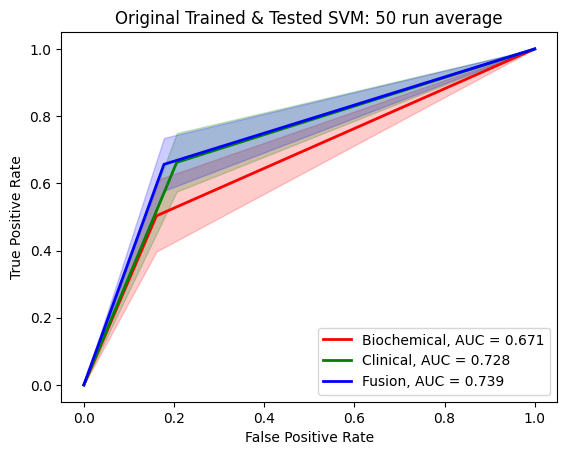

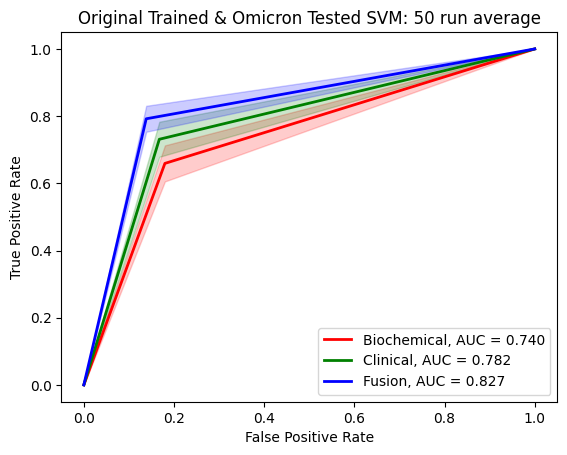

In [ ]:
# ROC Plots---------------------------------------------------------------------
# Plotting the average runs - Original Tested
fig, ax = plt.subplots()
ax.plot(bc_avg_fpr, bc_avg_tpr, label = 'Biochemical, AUC = %.3f'%bc_avg_auc, color='red', linewidth=2)
ax.plot(sy_avg_fpr, sy_avg_tpr, label = 'Clinical, AUC = %.3f'%sy_avg_auc, color='green', linewidth=2)
ax.plot(fn_avg_fpr, fn_avg_tpr, label = 'Fusion, AUC = %.3f'%fn_avg_auc, color='blue', linewidth=2)

# Intervals of 1 Standard Deviation
ax.fill_between(bc_avg_fpr, bc_avg_tpr + bc_std_tpr, bc_avg_tpr - bc_std_tpr, alpha=0.2, color='red')
ax.fill_between(sy_avg_fpr, sy_avg_tpr + sy_std_tpr, sy_avg_tpr - sy_std_tpr, alpha=0.2, color='green')
ax.fill_between(fn_avg_fpr, fn_avg_tpr + fn_std_tpr, fn_avg_tpr - fn_std_tpr, alpha=0.2, color='blue')

plt.title(label='Original Trained & Tested SVM: '+str(n_runs)+' run average')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Plotting the average runs - Omicron Tested
fig, ax = plt.subplots()
ax.plot(bc_avg_fpr1, bc_avg_tpr1, label = 'Biochemical, AUC = %.3f'%bc_avg_auc1, color='red', linewidth=2)
ax.plot(sy_avg_fpr1, sy_avg_tpr1, label = 'Clinical, AUC = %.3f'%sy_avg_auc1, color='green', linewidth=2)
ax.plot(fn_avg_fpr1, fn_avg_tpr1, label = 'Fusion, AUC = %.3f'%fn_avg_auc1, color='blue', linewidth=2)

# Intervals of 1 Standard Deviation
ax.fill_between(bc_avg_fpr1, bc_avg_tpr1 + bc_std_tpr1, bc_avg_tpr1 - bc_std_tpr1, alpha=0.2, color='red')
ax.fill_between(sy_avg_fpr1, sy_avg_tpr1 + sy_std_tpr1, sy_avg_tpr1 - sy_std_tpr1, alpha=0.2, color='green')
ax.fill_between(fn_avg_fpr1, fn_avg_tpr1 + fn_std_tpr1, fn_avg_tpr1 - fn_std_tpr1, alpha=0.2, color='blue')

plt.title(label='Original Trained & Omicron Tested SVM: '+str(n_runs)+' run average')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Omicron Trained Model

---



#### Hyperparameter Tuning, Training, and Prediction

In [ ]:
# Support Vector Machines - Omicron---------------------------------------------

print('Omicron Data Runs\n')

# Parameter Grid
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid')}

# FPR recordings: 1 - TNR, for plotting ROC
bcO_fpr_runs = [] # Omicron trained and tested
syO_fpr_runs = []
fnO_fpr_runs = []

bcO_fpr_runs1 = [] # Omicron trained and original tested
syO_fpr_runs1 = []
fnO_fpr_runs1 = []

# TPR recordings: Sensitivity, Recall
bcO_tpr_runs = [] # Omicron trained and tested
syO_tpr_runs = []
fnO_tpr_runs = []

bcO_tpr_runs1 = [] # Omicron trained and original tested
syO_tpr_runs1 = []
fnO_tpr_runs1 = []

# TNR recordings: Specificity, Sensitivity
bcO_tnr_runs = [] # Omicron Trained and Tested
syO_tnr_runs = []
fnO_tnr_runs = []

bcO_tnr_runs1 = [] # Omicron Trained and original Tested
syO_tnr_runs1 = []
fnO_tnr_runs1 = []

# AUC recordings
bcO_auc_runs = [] # Omicron trained and tested
syO_auc_runs = []
fnO_auc_runs = []

bcO_auc_runs1 = [] # Omicron trained and original tested
syO_auc_runs1 = []
fnO_auc_runs1 = []

# Best parameter recordings
bcO_params = []
syO_params = []
fnO_params = []

for i in range(n_runs):
  j = i+1
  print('Run: ',j,'------------------------------------\n')

  # Train Test Split------------------------------------------------------------
  bioChemO_train, bioChemO_test, bioChemO_labels_train, bioChemO_labels_test = train_test_split(bioChemO_trim, bioChemO_labels, test_size = 1 / 5)
  sympO_train, sympO_test, sympO_labels_train, sympO_labels_test = train_test_split(sympO_trim, sympO_labels, test_size = 1 / 5)
  multiO_train, multiO_test, multiO_labels_train, multiO_labels_test = train_test_split(multiO_trim, multiO_labels, test_size = 1 / 5)

  # Scaling---------------------------------------------------------------------
  # Biochemical Data
  bioChemO_scaler = StandardScaler()
  bioChemO_train = bioChemO_scaler.fit_transform(bioChemO_train)
  bioChemO_test = bioChemO_scaler.transform(bioChemO_test)

  # Clinical Data
  sympO_scaler = StandardScaler()
  sympO_train = sympO_scaler.fit_transform(sympO_train)
  sympO_test = sympO_scaler.transform(sympO_test)

  # Fusion Data
  multiO_scaler = StandardScaler()
  multiO_train = multiO_scaler.fit_transform(multiO_train)
  multiO_test = multiO_scaler.transform(multiO_test)

  # Model Training Grid Search--------------------------------------------------
  bioChemO_SVM = svm.SVC()
  bioChemO_clf = GridSearchCV(bioChemO_SVM, parameters)
  bioChemO_clf.fit(bioChemO_train, bioChemO_labels_train)

  # Clinical model
  sympO_SVM = svm.SVC()
  sympO_clf = GridSearchCV(sympO_SVM, parameters)
  sympO_clf.fit(sympO_train, sympO_labels_train)

  # Fusion model
  multiO_SVM = svm.SVC()
  multiO_clf = GridSearchCV(multiO_SVM, parameters)
  multiO_clf.fit(multiO_train, multiO_labels_train)

  # View results----------------------------------------------------------------
  target_names = ['Non-Severe COVID', 'Severe COVID']

  # Biochemical results---------------------------------------------------------
  print('Biochemical Results\n')

  # Best estimator
  bcO_params.append(bioChemO_clf.best_params_)

  # Predicting on testing hold-out data
  bioChemO_labels_predict = bioChemO_clf.predict(bioChemO_test)

  # Predicting on original COIVD-19 data
  bioChem_trim_scale = bioChemO_scaler.transform(bioChem_trim)
  bioChem_labels_predict1 = bioChemO_clf.predict(bioChem_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(bioChemO_labels_test, bioChemO_labels_predict)
  bcO_fpr_runs.append(fpr)
  bcO_tpr_runs.append(tpr)

  # Original testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(bioChem_labels, bioChem_labels_predict1)
  bcO_fpr_runs1.append(fpr1)
  bcO_tpr_runs1.append(tpr1)

  # AUC
  BCO_roc_auc = metrics.auc(fpr, tpr)
  bcO_auc_runs.append(BCO_roc_auc)

  # AUC - Original
  BCO_roc_auc1 = metrics.auc(fpr1, tpr1)
  bcO_auc_runs1.append(BCO_roc_auc1)

  # Clinical results---------------------------------------------------------
  print('Clinical Results\n')

  # Best estimator
  syO_params.append(sympO_clf.best_params_)

  # Predicting on testing hold-out data
  sympO_labels_predict = sympO_clf.predict(sympO_test)

  # Predicting on original COIVD-19 data
  symp_trim_scale = sympO_scaler.transform(symp_trim)
  symp_labels_predict1 = sympO_clf.predict(symp_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(sympO_labels_test, sympO_labels_predict)
  syO_fpr_runs.append(fpr)
  syO_tpr_runs.append(tpr)

  # Original testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(symp_labels, symp_labels_predict1)
  syO_fpr_runs1.append(fpr1)
  syO_tpr_runs1.append(tpr1)

  # AUC
  SYO_roc_auc = metrics.auc(fpr, tpr)
  syO_auc_runs.append(SYO_roc_auc)

  # AUC - Original
  SYO_roc_auc1 = metrics.auc(fpr1, tpr1)
  syO_auc_runs1.append(SYO_roc_auc1)

  # Fusion results--------------------------------------------------------------
  print('Fusion Results\n')

  # Best estimator
  fnO_params.append(multiO_clf.best_params_)

  # Predicting on testing hold-out data
  multiO_labels_predict = multiO_clf.predict(multiO_test)

  # Predicting on original COIVD-19 data
  multi_trim_scale = multiO_scaler.transform(multi_trim)
  multi_labels_predict1 = multiO_clf.predict(multi_trim_scale)

  # Saving fpr and tpr
  fpr, tpr, thresholds = metrics.roc_curve(multiO_labels_test, multiO_labels_predict)
  fnO_fpr_runs.append(fpr)
  fnO_tpr_runs.append(tpr)

  # Original testing
  fpr1, tpr1, thresholds1 = metrics.roc_curve(multi_labels, multi_labels_predict1)
  fnO_fpr_runs1.append(fpr1)
  fnO_tpr_runs1.append(tpr1)

  # AUC
  FNO_roc_auc = metrics.auc(fpr, tpr)
  fnO_auc_runs.append(FNO_roc_auc)

  # AUC - Original
  FNO_roc_auc1 = metrics.auc(fpr1, tpr1)
  fnO_auc_runs1.append(FNO_roc_auc1)

print(bcO_params)
print(syO_params)
print(fnO_params)

Omicron Data Runs

Run:  1 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  2 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  3 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  4 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  5 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  6 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  7 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  8 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  9 ------------------------------------

Biochemical Results

Clinical Results

Fusion Results

Run:  10 ------------------------------------

Biochemical Results

Clin

#### Calculating Mean and Standard Deviation of metrics

In [ ]:
bcO_avg_fpr, bcO_avg_fpr1, bcO_avg_tpr, bcO_avg_tpr1, bcO_avg_auc, bcO_avg_auc1, bcO_std_fpr, bcO_std_fpr1, bcO_std_tpr, bcO_std_tpr1, bcO_std_auc, bcO_std_auc1 = get_Stats(bcO_fpr_runs,bcO_fpr_runs1,bcO_tpr_runs,bcO_tpr_runs1,bcO_auc_runs,bcO_auc_runs1)
syO_avg_fpr, syO_avg_fpr1, syO_avg_tpr, syO_avg_tpr1, syO_avg_auc, syO_avg_auc1, syO_std_fpr, syO_std_fpr1, syO_std_tpr, syO_std_tpr1, syO_std_auc, syO_std_auc1 = get_Stats(syO_fpr_runs,syO_fpr_runs1,syO_tpr_runs,syO_tpr_runs1,syO_auc_runs,syO_auc_runs1)
fnO_avg_fpr, fnO_avg_fpr1, fnO_avg_tpr, fnO_avg_tpr1, fnO_avg_auc, fnO_avg_auc1, fnO_std_fpr, fnO_std_fpr1, fnO_std_tpr, fnO_std_tpr1, fnO_std_auc, fnO_std_auc1 = get_Stats(fnO_fpr_runs,fnO_fpr_runs1,fnO_tpr_runs,fnO_tpr_runs1,fnO_auc_runs,fnO_auc_runs1)

#### Printing Stats

In [ ]:
# Printing Results--------------------------------------------------------------
# FPR
print('Mean FPR, original/original, BC: ', bcO_avg_fpr)
print('Mean FPR, original/original, SY: ', syO_avg_fpr)
print('Mean FPR, original/original, FN: ', fnO_avg_fpr)

# FPR - Omicron
print('Mean FPR, original/omicron, BC: ', bcO_avg_fpr1)
print('Mean FPR, original/omicron, SY: ', syO_avg_fpr1)
print('Mean FPR, original/omicron, FN: ', fnO_avg_fpr1)

print('\n')

# TPR
print('Mean TPR, original/original, BC: ', bcO_avg_tpr)
print('Mean TPR, original/original, SY: ', syO_avg_tpr)
print('Mean TPR, original/original, FN: ', fnO_avg_tpr)

# TPR - Omicron
print('Mean TPR, original/omicron, BC: ', bcO_avg_tpr1)
print('Mean TPR, original/omicron, SY: ', syO_avg_tpr1)
print('Mean TPR, original/omicron, FN: ', fnO_avg_tpr1)
"""
print('\n')

# TNR
print('Mean TNR, original/original, BC: ', bc_avg_tnr)
print('Mean TNR, original/original, SY: ', sy_avg_tnr)
print('Mean TNR, original/original, FN: ', fn_avg_tnr)

# TNR - Omicron
print('Mean TNR, original/omicron, BC: ', bc_avg_tnr1)
print('Mean TNR, original/omicron, SY: ', sy_avg_tnr1)
print('Mean TNR, original/omicron, FN: ', fn_avg_tnr1)

print('\n')"""
print('\n')

# AUC
print('AUC of biochem composite ROC curve',metrics.auc(bcO_avg_fpr, bc_avg_tpr))
print('AUC of symp composite ROC curve',metrics.auc(syO_avg_fpr, sy_avg_tpr))
print('AUC of fusion composite ROC curve',metrics.auc(fnO_avg_fpr, fn_avg_tpr))
print('\n')

# AUC - Original
print('AUC of biochem composite ROC curve (Original)',metrics.auc(bcO_avg_fpr1, bc_avg_tpr1))
print('AUC of symp composite ROC curve (Original)',metrics.auc(syO_avg_fpr1, sy_avg_tpr1))
print('AUC of fusion composite ROC curve (Original)',metrics.auc(fnO_avg_fpr1, fn_avg_tpr1))
print('\n')

# AUC
print('AUC STDEV of biochem composite ROC curve',bcO_std_auc)
print('AUC STDEV of symp composite ROC curve',syO_std_auc)
print('AUC STDEV of fusion composite ROC curve',fnO_std_auc)
print('\n')

# AUC - Original
print('AUC STDEV of biochem composite ROC curve (Original)',bcO_std_auc1)
print('AUC STDEV of symp composite ROC curve (Original)',syO_std_auc1)
print('AUC STDEV of fusion composite ROC curve (Original)',fnO_std_auc1)

Mean FPR, original/original, BC:  [0.         0.11961074 1.        ]
Mean FPR, original/original, SY:  [0.         0.19836298 1.        ]
Mean FPR, original/original, FN:  [0.         0.09480933 1.        ]
Mean FPR, original/omicron, BC:  [0.         0.22084112 1.        ]
Mean FPR, original/omicron, SY:  [0.         0.22962617 1.        ]
Mean FPR, original/omicron, FN:  [0.        0.2082243 1.       ]


Mean TPR, original/original, BC:  [0.         0.82548346 1.        ]
Mean TPR, original/original, SY:  [0.         0.81534438 1.        ]
Mean TPR, original/original, FN:  [0.        0.9111995 1.       ]
Mean TPR, original/omicron, BC:  [0.         0.57324324 1.        ]
Mean TPR, original/omicron, SY:  [0.         0.76689189 1.        ]
Mean TPR, original/omicron, FN:  [0.         0.70608108 1.        ]


AUC of biochem composite ROC curve 0.6917714600478992
AUC of symp composite ROC curve 0.7319894878696556
AUC of fusion composite ROC curve 0.7808275057034407


AUC of biochem compo

#### Displaying ROC Plots and AUC

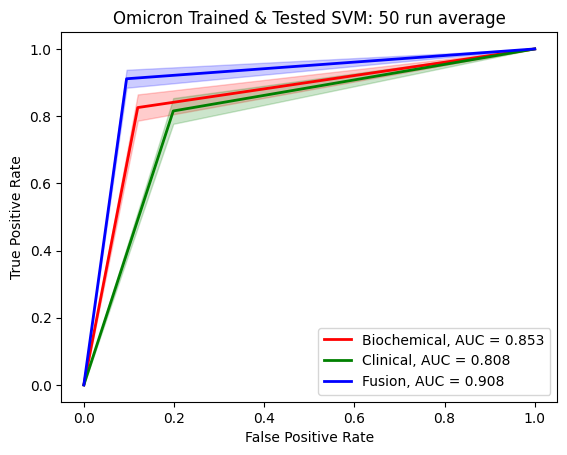

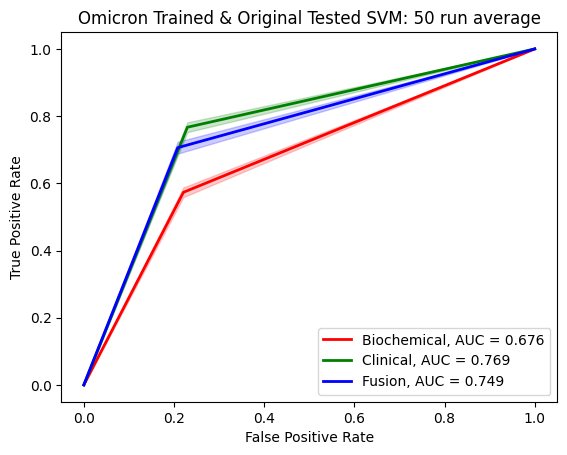

In [ ]:
# ROC Plots---------------------------------------------------------------------
# Plotting the average runs - Omicron Tested
fig, ax = plt.subplots()
ax.plot(bcO_avg_fpr, bcO_avg_tpr, label = 'Biochemical, AUC = %.3f'%bcO_avg_auc, color='red', linewidth=2)
ax.plot(syO_avg_fpr, syO_avg_tpr, label = 'Clinical, AUC = %.3f'%syO_avg_auc, color='green', linewidth=2)
ax.plot(fnO_avg_fpr, fnO_avg_tpr, label = 'Fusion, AUC = %.3f'%fnO_avg_auc, color='blue', linewidth=2)

# Intervals of 1 Standard Deviation
ax.fill_between(bcO_avg_fpr, bcO_avg_tpr + bcO_std_tpr, bcO_avg_tpr - bcO_std_tpr, alpha=0.2, color='red')
ax.fill_between(syO_avg_fpr, syO_avg_tpr + syO_std_tpr, syO_avg_tpr - syO_std_tpr, alpha=0.2, color='green')
ax.fill_between(fnO_avg_fpr, fnO_avg_tpr + fnO_std_tpr, fnO_avg_tpr - fnO_std_tpr, alpha=0.2, color='blue')

plt.title(label='Omicron Trained & Tested SVM: '+str(n_runs)+' run average')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Plotting the average runs - Original Tested
fig, ax = plt.subplots()
ax.plot(bcO_avg_fpr1, bcO_avg_tpr1, label = 'Biochemical, AUC = %.3f'%bcO_avg_auc1, color='red', linewidth=2)
ax.plot(syO_avg_fpr1, syO_avg_tpr1, label = 'Clinical, AUC = %.3f'%syO_avg_auc1, color='green', linewidth=2)
ax.plot(fnO_avg_fpr1, fnO_avg_tpr1, label = 'Fusion, AUC = %.3f'%fnO_avg_auc1, color='blue', linewidth=2)

# Intervals of 1 Standard Deviation
ax.fill_between(bcO_avg_fpr1, bcO_avg_tpr1 + bcO_std_tpr1, bcO_avg_tpr1 - bcO_std_tpr1, alpha=0.2, color='red')
ax.fill_between(syO_avg_fpr1, syO_avg_tpr1 + syO_std_tpr1, syO_avg_tpr1 - syO_std_tpr1, alpha=0.2, color='green')
ax.fill_between(fnO_avg_fpr1, fnO_avg_tpr1 + fnO_std_tpr1, fnO_avg_tpr1 - fnO_std_tpr1, alpha=0.2, color='blue')

plt.title(label='Omicron Trained & Original Tested SVM: '+str(n_runs)+' run average')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()